# 🚓🕵️ Dutch Crime Data: Increasing or decreasing? Diverging trends

This project uses crime data from 2012-2024 collected by [Politie Nederland](https://data.politie.nl/portal.html?_la=nl&_catalog=Politie&tableId=47013NED&_theme=115) and population data from the same period collected by the [Centraal Bureau voor Statistiek (CBS)](https://opendata.cbs.nl/#/CBS/nl/dataset/37230ned/table?ts=1766338546563) to calculate the total and violent crime rates per 1000 people at different geographic levels across the Netherlands. 

<b>📊Data Quality & Cleaning Notes</b>
- This project looks at 298 administrative areas in the Netherlands that had complete crime and population data for the period 2012-2024.
- Interpolation was not used to fill null values, given that the rates of change in both crime and population are known to be highly variable year on year and differ particularly strongly between urban and rural areas. Therefore, applying constant rates of change through interpolation was avoided and instead administrative areas with null values for total crime counts or population in any year between 2012 and 2024 were excluded from the analysis.

<b>❓This project seeks to answer the following questions:</b>
1) Has crime in the Netherlands actually been increasing, as many people seem to believe?
2) Is there a difference in how violent crime rates have changed compared to total crime rates?
3) Which regions have the highest overall and violent crime rates?
4) Which of the major cities have historically had and currently have the highest crime rates?
5) Are there substantial differences in crime rates between two Dutch regions most often in the news for crime: the Randstad and Brabant?

<b> 📈 Key Performance Indicators (KPIs), each disaggregated on the national, regional and city level, include:</b>
- Total crime rate per 1000 people: total crime includes all crime categories listed in the crime data from Politie Nederland including violent crime, thievery, environmental crime, traffic crime, etc.
- Violent crime rate per 1000 people: violent crime is calculated based on crimes including physical violence (i.e. mugging, robbery, sex crimes, assault, threats, etc.)

<b> ✅ The project is organized in the following sections:</b>
- Data prep (including importing, inspecting, cleaning, transforming and merging the crime and population data)
- Analysis per question
- Correlation analysis of population vs. crime rates (WORK IN PROGRESS)

<b> 🔎 Main findings:</b>
- <b><i>Total crime per 1000 people has decreased substantially on the national level</b></i> since 2012, including compared to pre-pandemic levels.
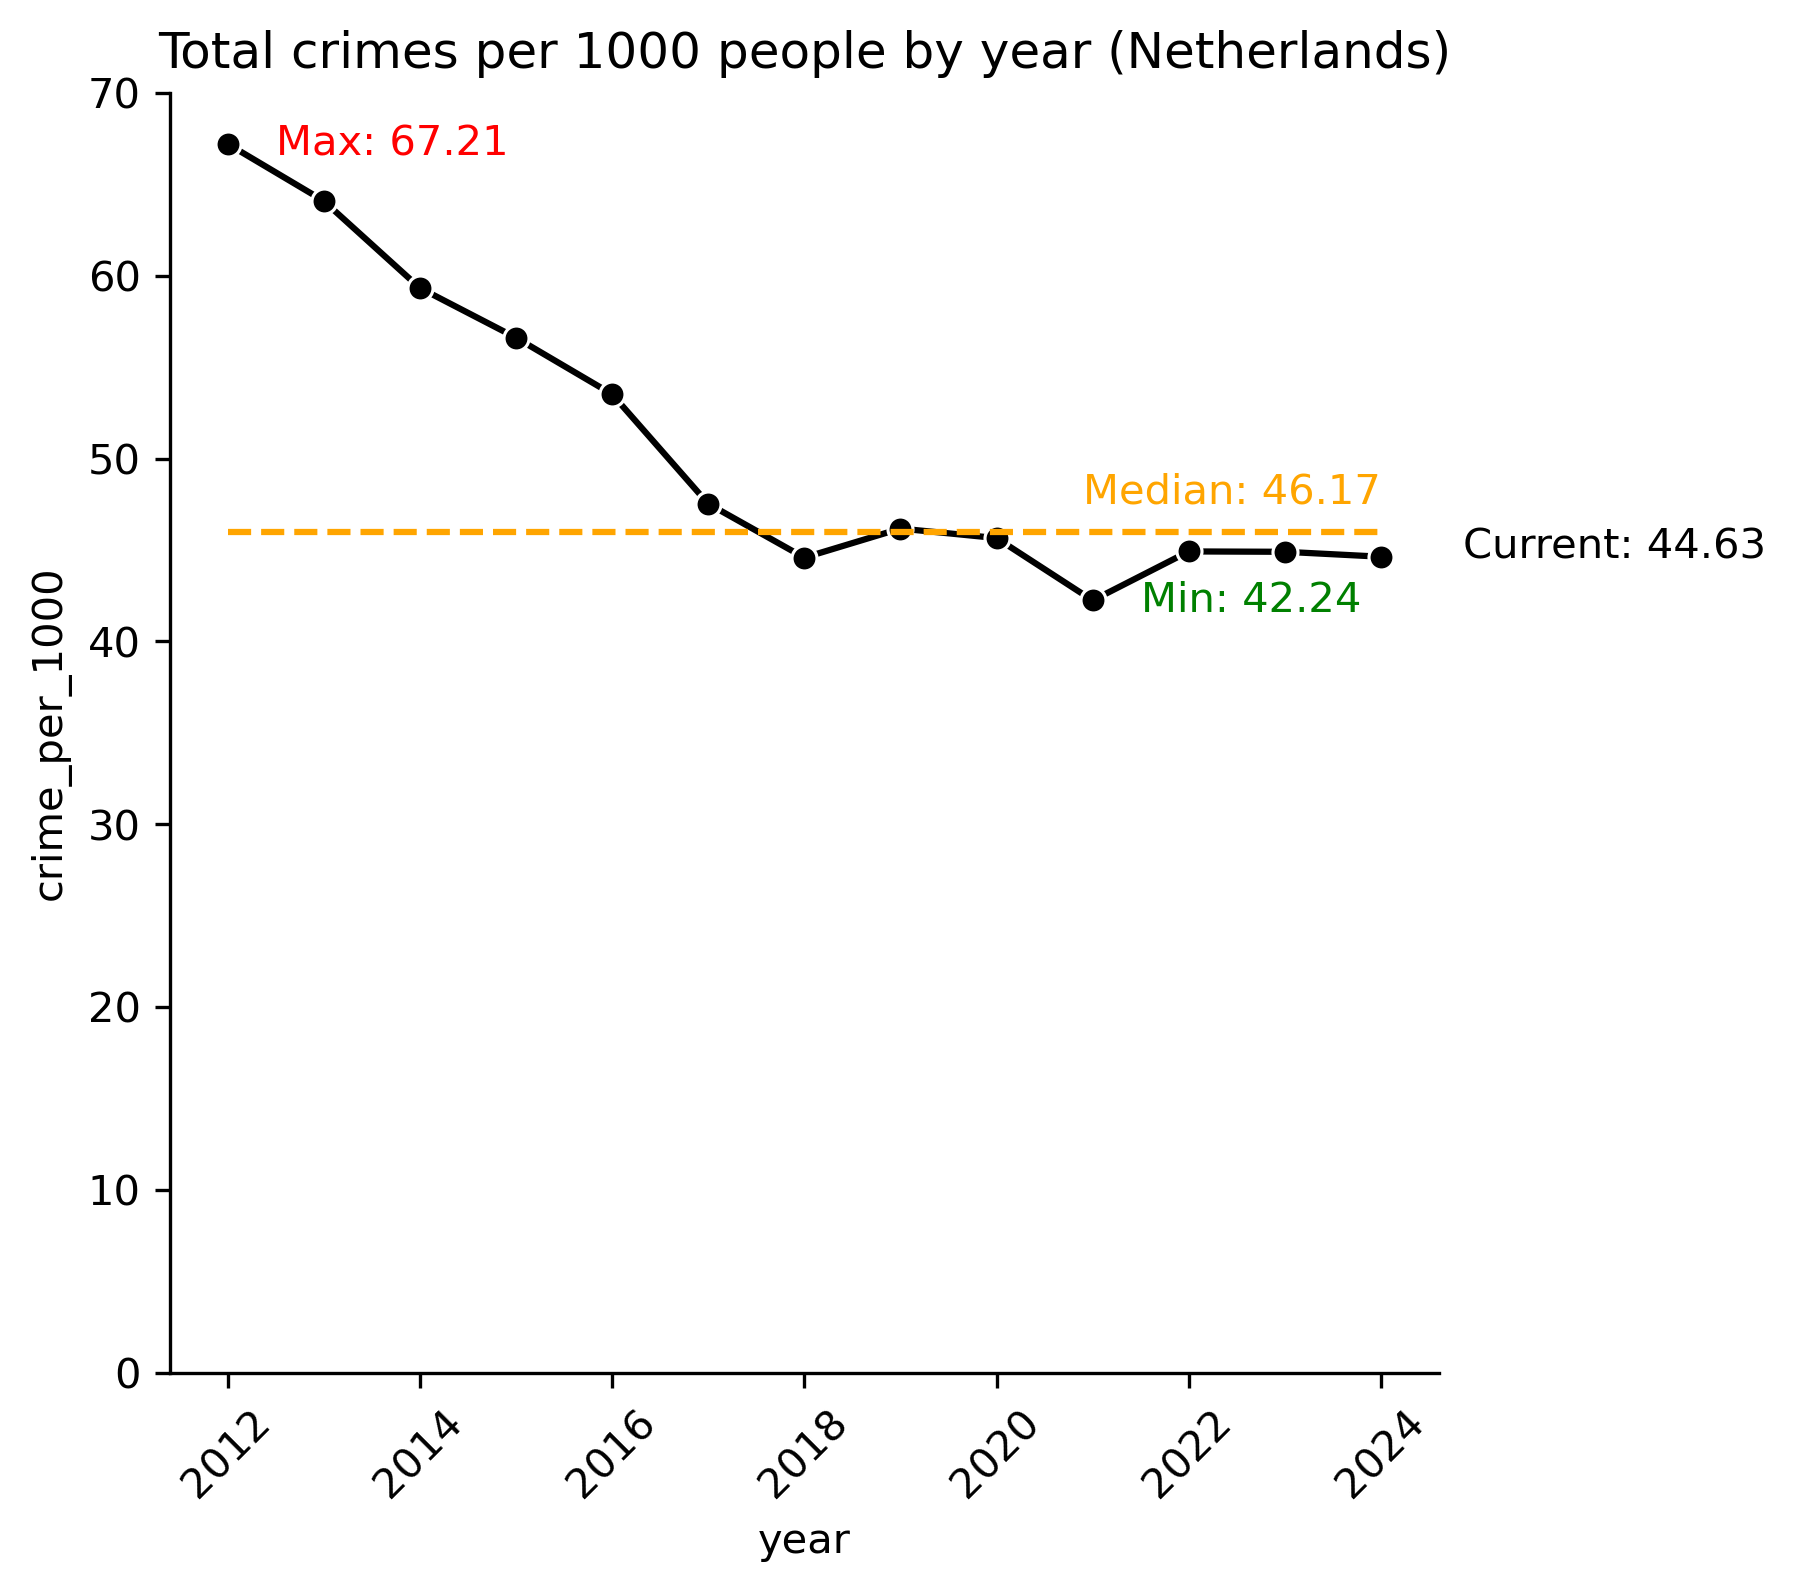
- The data shows a clear, diverging pattern of a <b><i>steady and signficiant national decrease in both total and violent crime rates, but many local increases in total crime rate and, in some cases, also violent crime rate</b></i>.
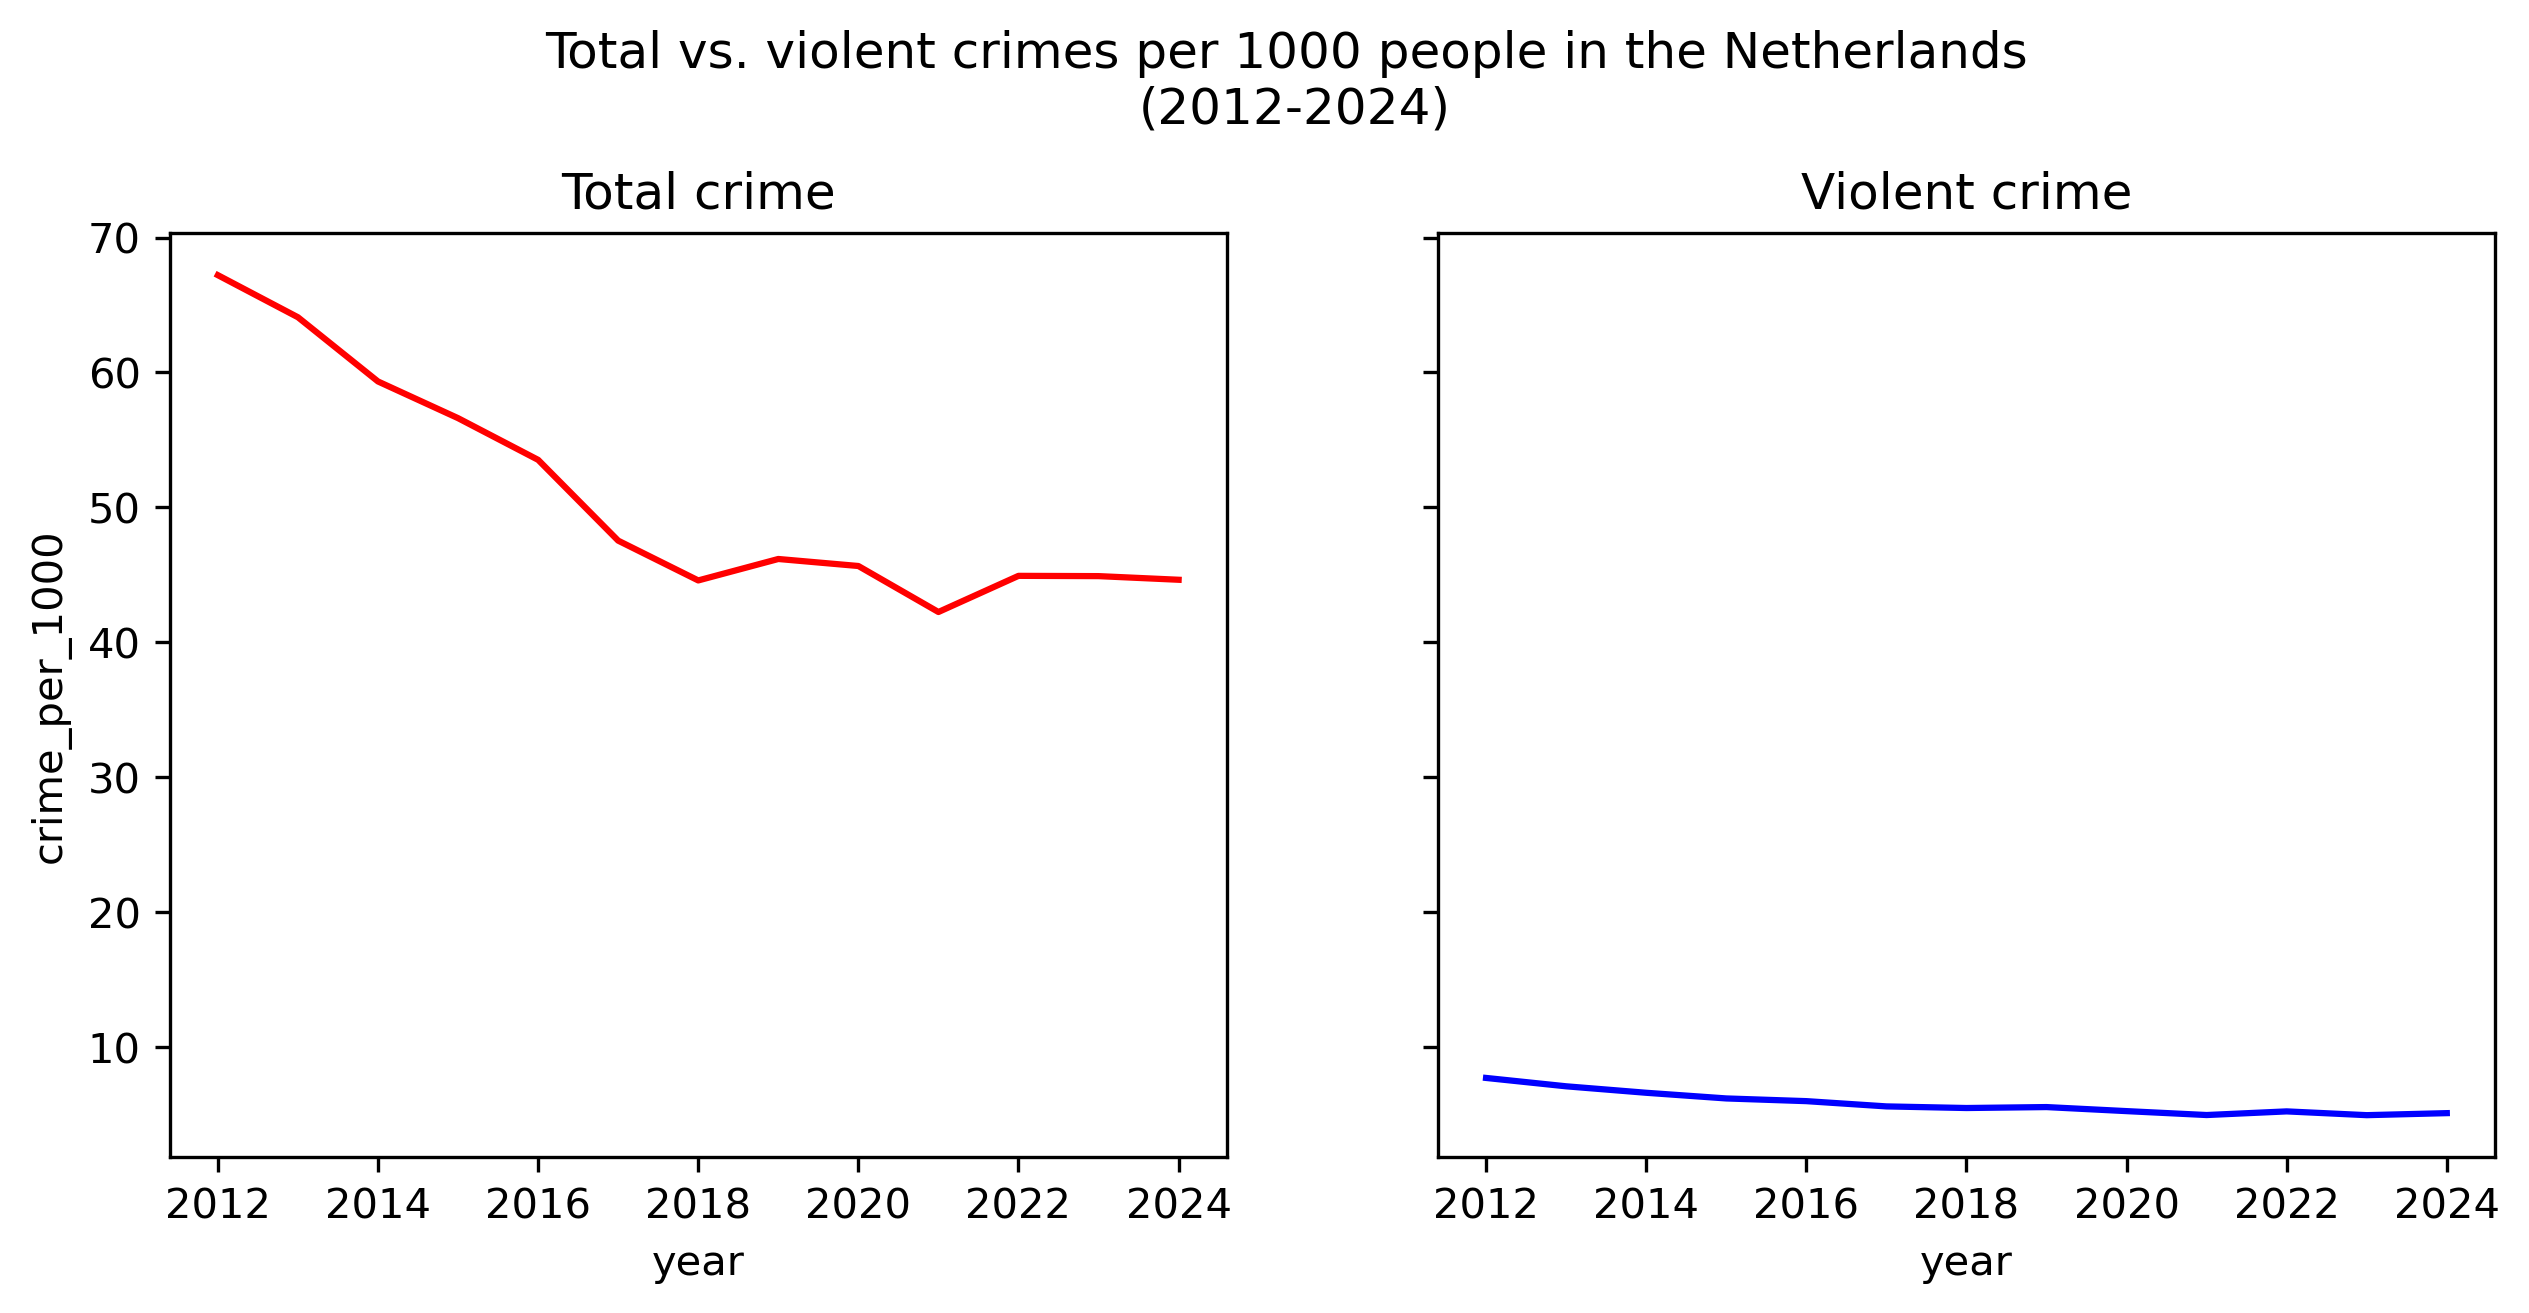
- While total and violent crime nationally continue its decreasing trend after the pandemic, <b><i>for many reigons and cities, the pandemic was an inflection point</b></i> that sharply changed the decreasing trend to one of increasing total and violent crime rates since 2020.
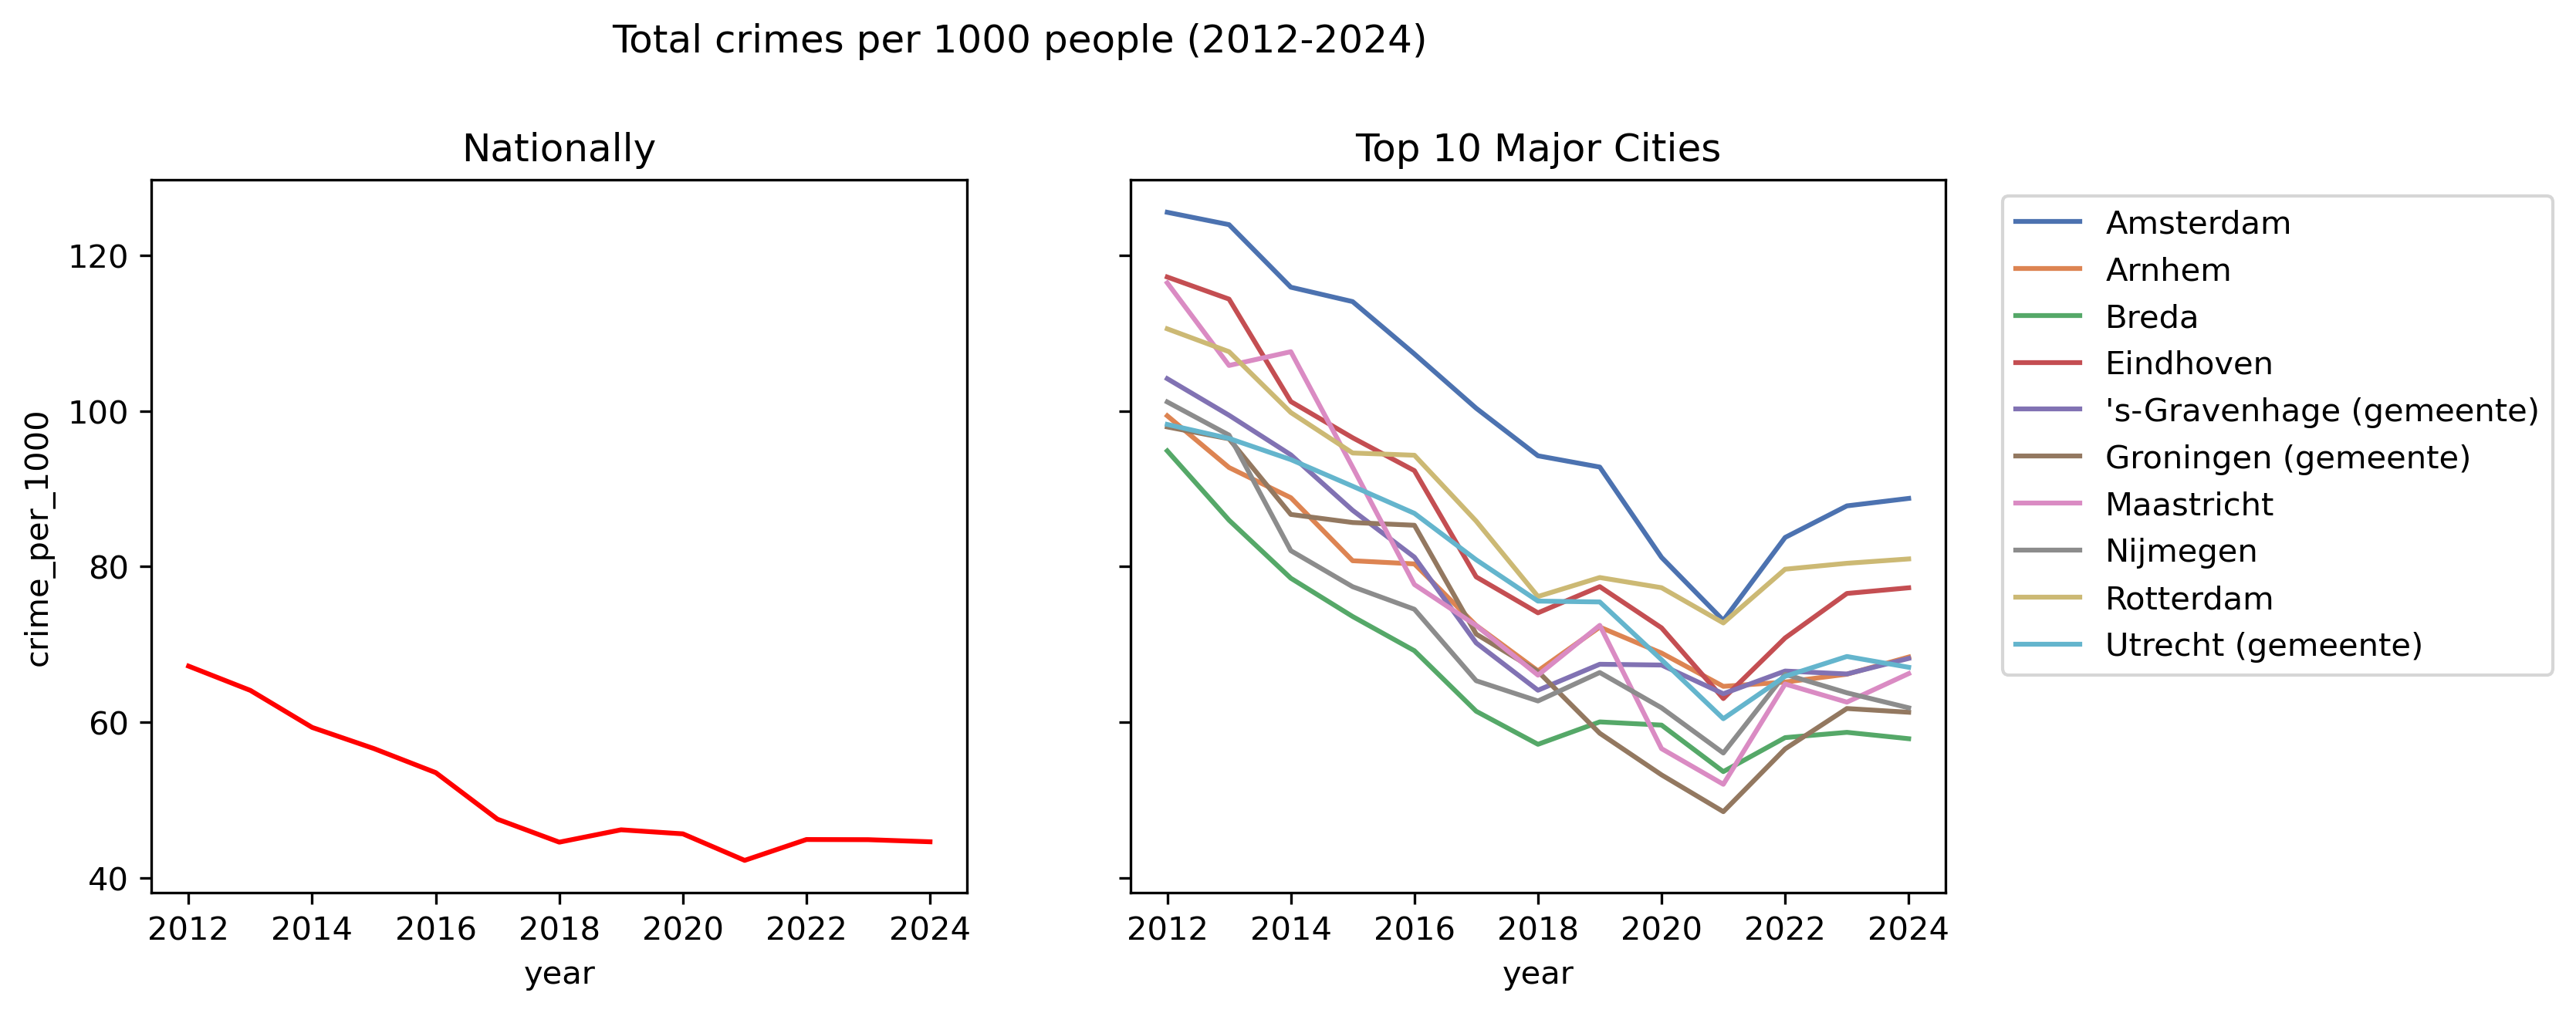
- On the regional level, Noord Holland, Zuid Holland and Limburg lead the regions in terms of both the total crime rate and violent crime rate per 1000 people. However, Zeeland, Overijssel and Groningen have experienced the largest percentage increases in total crime rate relative to pre-pandemic levels (2019).
- <b><i>While Utrecht province places 5th overall in terms of total crime rate, it bucks the trend of total crime tracking violent crime by having the lowest violent crime rate of all the provinces.</b></i>
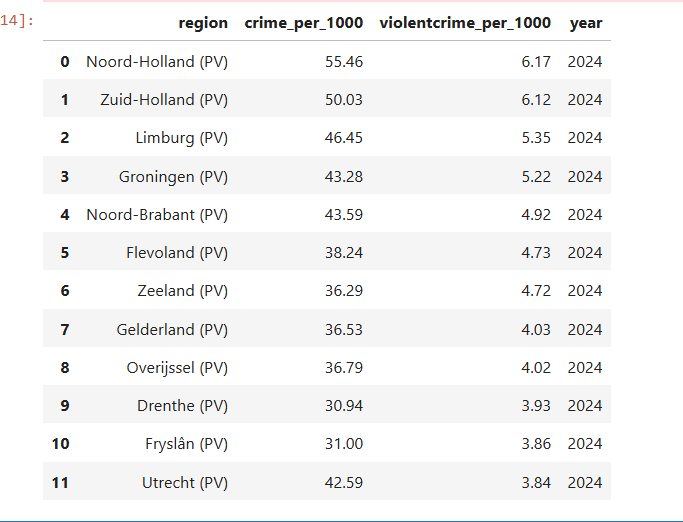
- Many cities show a similar pattern of following the steady decline in total crime levels seen at the national level up until the pandemic, yet with total crime rates increasing thereafter. <b><i>Amsterdam, Rotterdam and Eindhoven show both the highest average total crime rates historically and the highest currrent total crime rates as of 2024. However, only Groningen, Rotterdam and Den Haag show total crime rates that surpass their pre-pandemic levels (2019).</b></i>
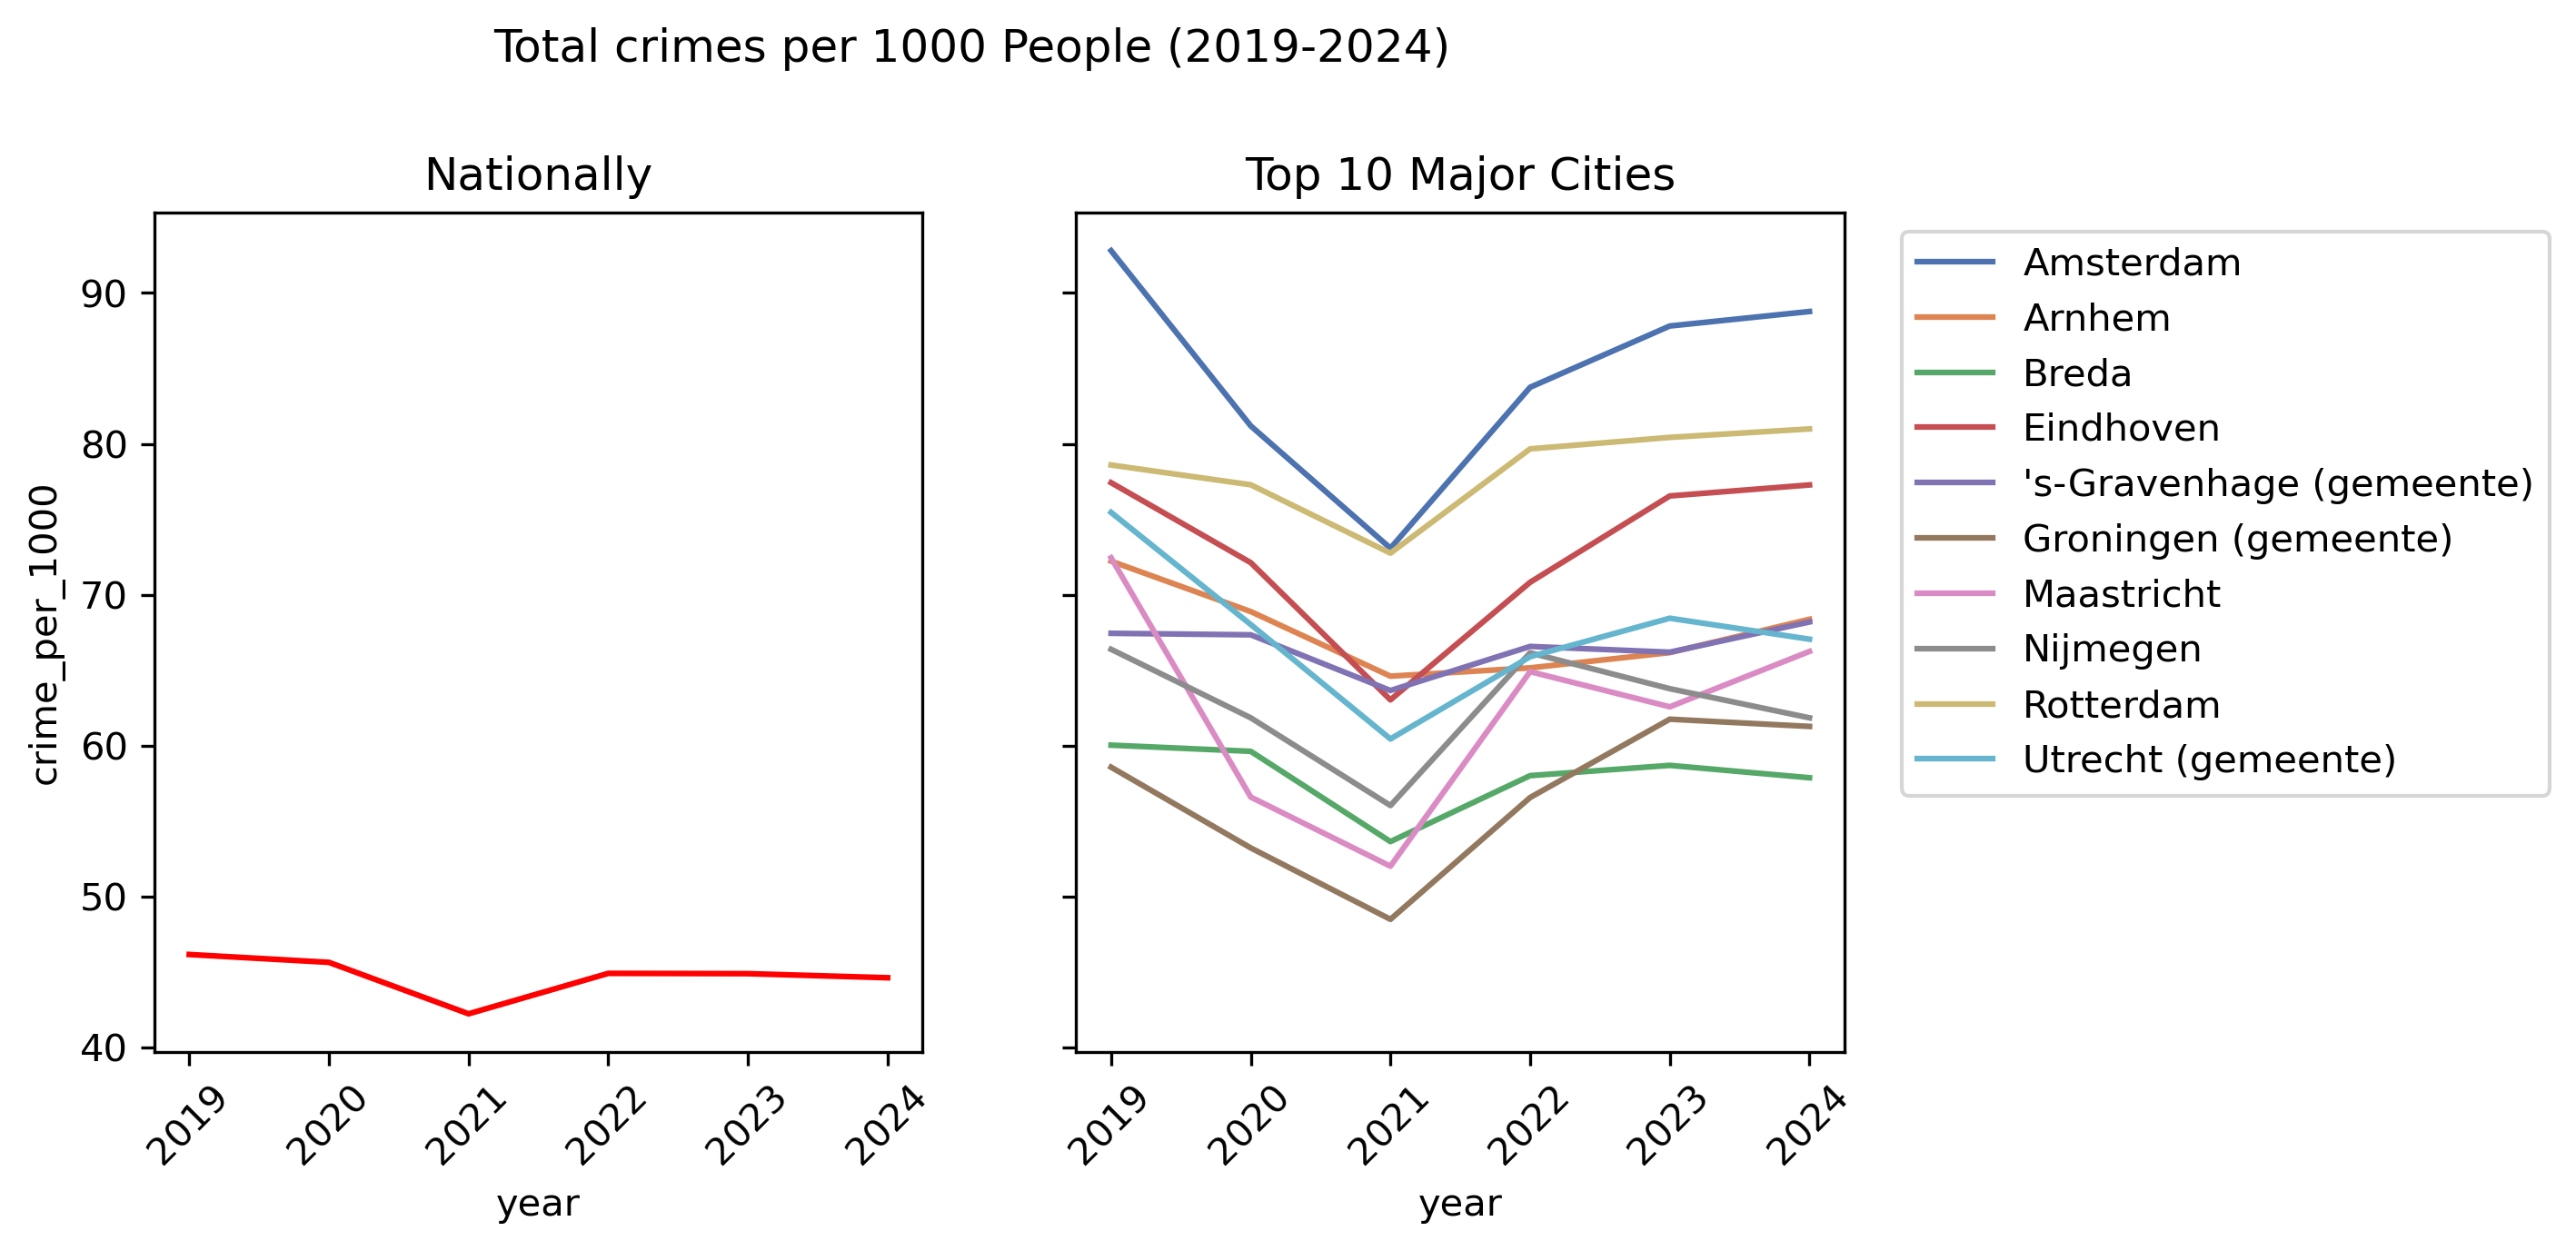
- In contrast to the trends for total crime, the trends for violent crime rates in cities show much more variation among them. <b><i>Although Amsterdam and Rotterdam are also in the top 3 cities for 2024 violent crime rates per 1000 people, Heerlen ties with Rotterdam for first place.</b></i>
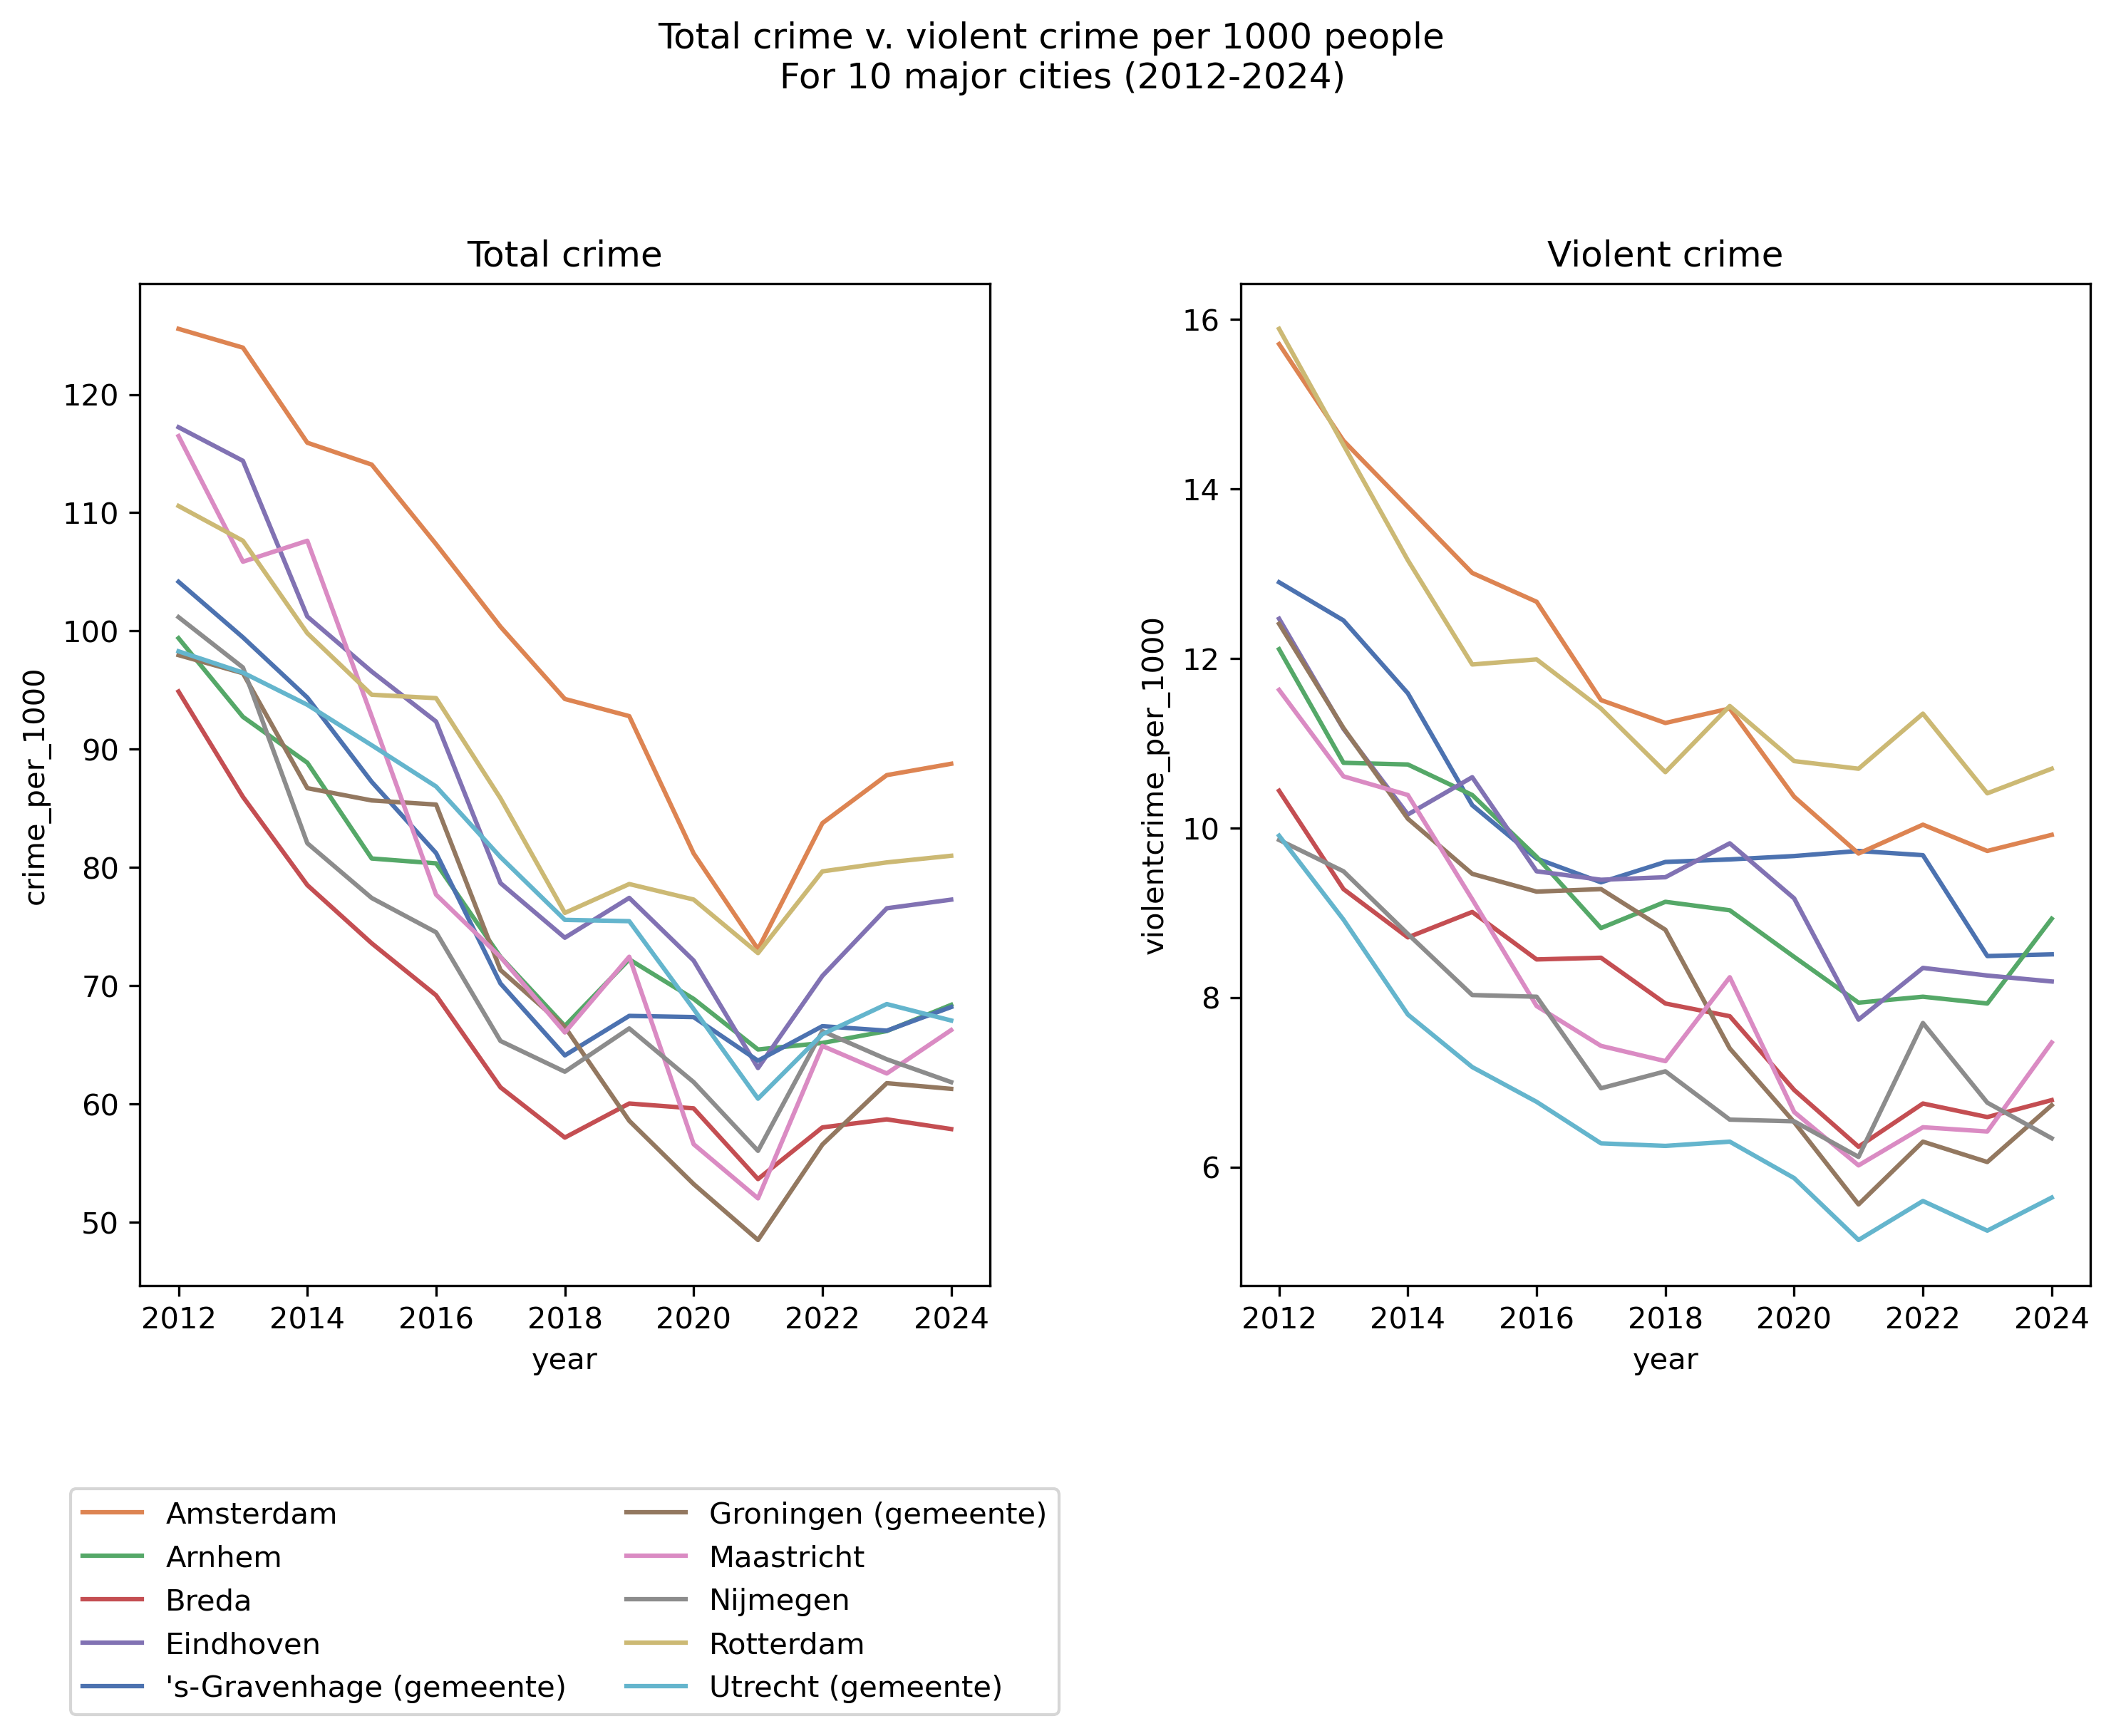
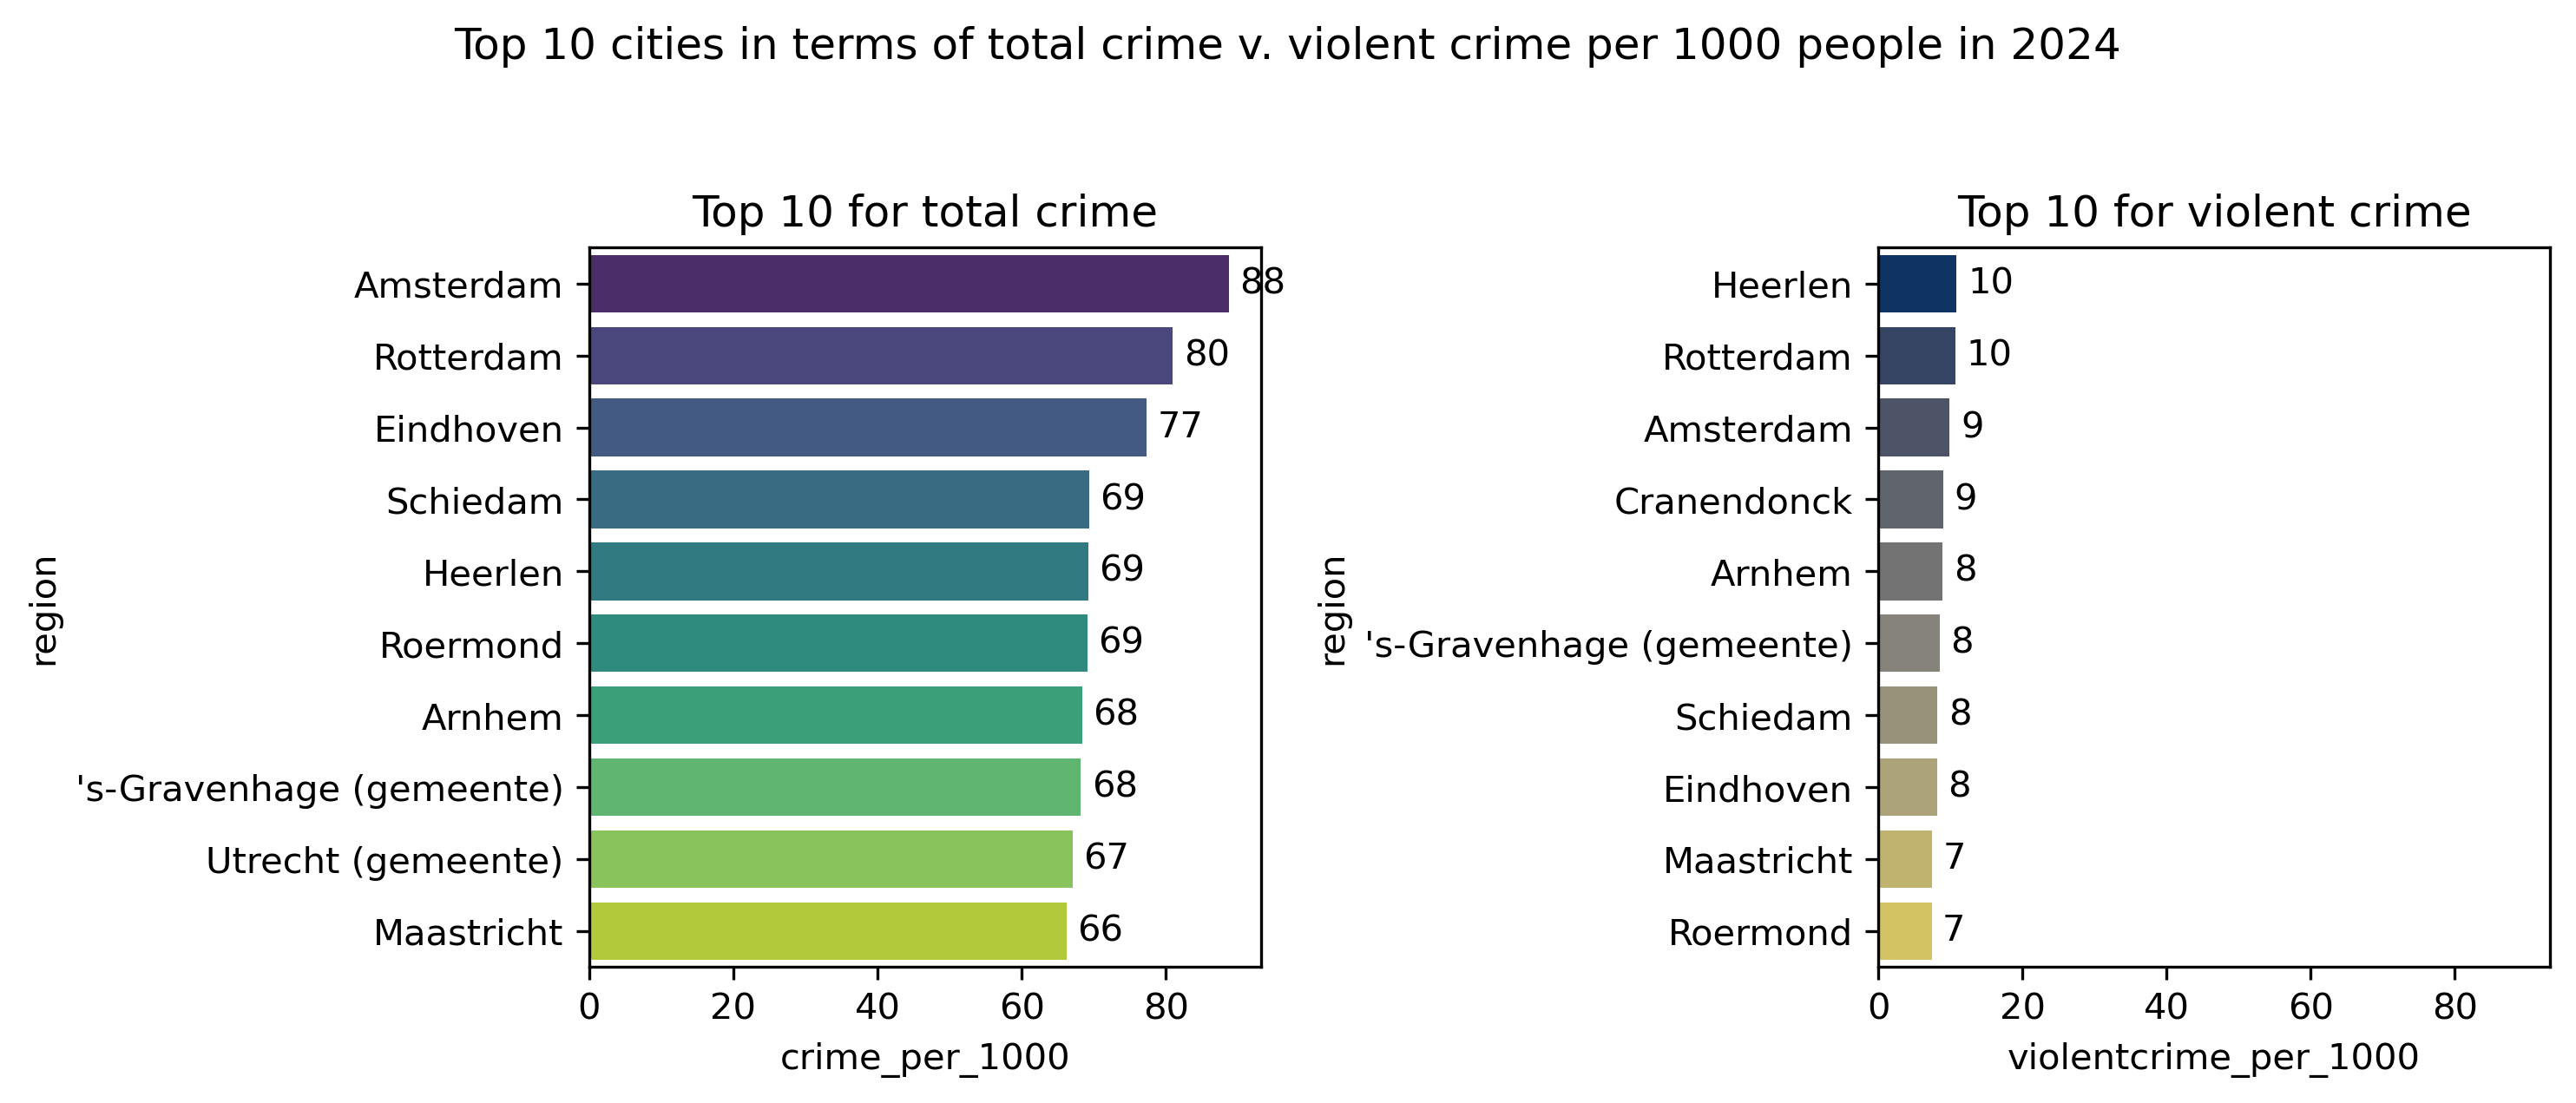
- When comparing major cities in the Randstad v. Brabant, <b><i>cities in the Randstad show total crime rates significantly higher than Brabant cities, with the exception of Eindhoven</b></i>, which shows a total crime rate comparable to those seen in the Randstad. In contrast, violent crime rates are relatively comparable among Randstad and Brabant cities, with the exception of Utrecht city, which has an exceptionally low violent crime rate both historically and in 2024 compared to other cities.
- 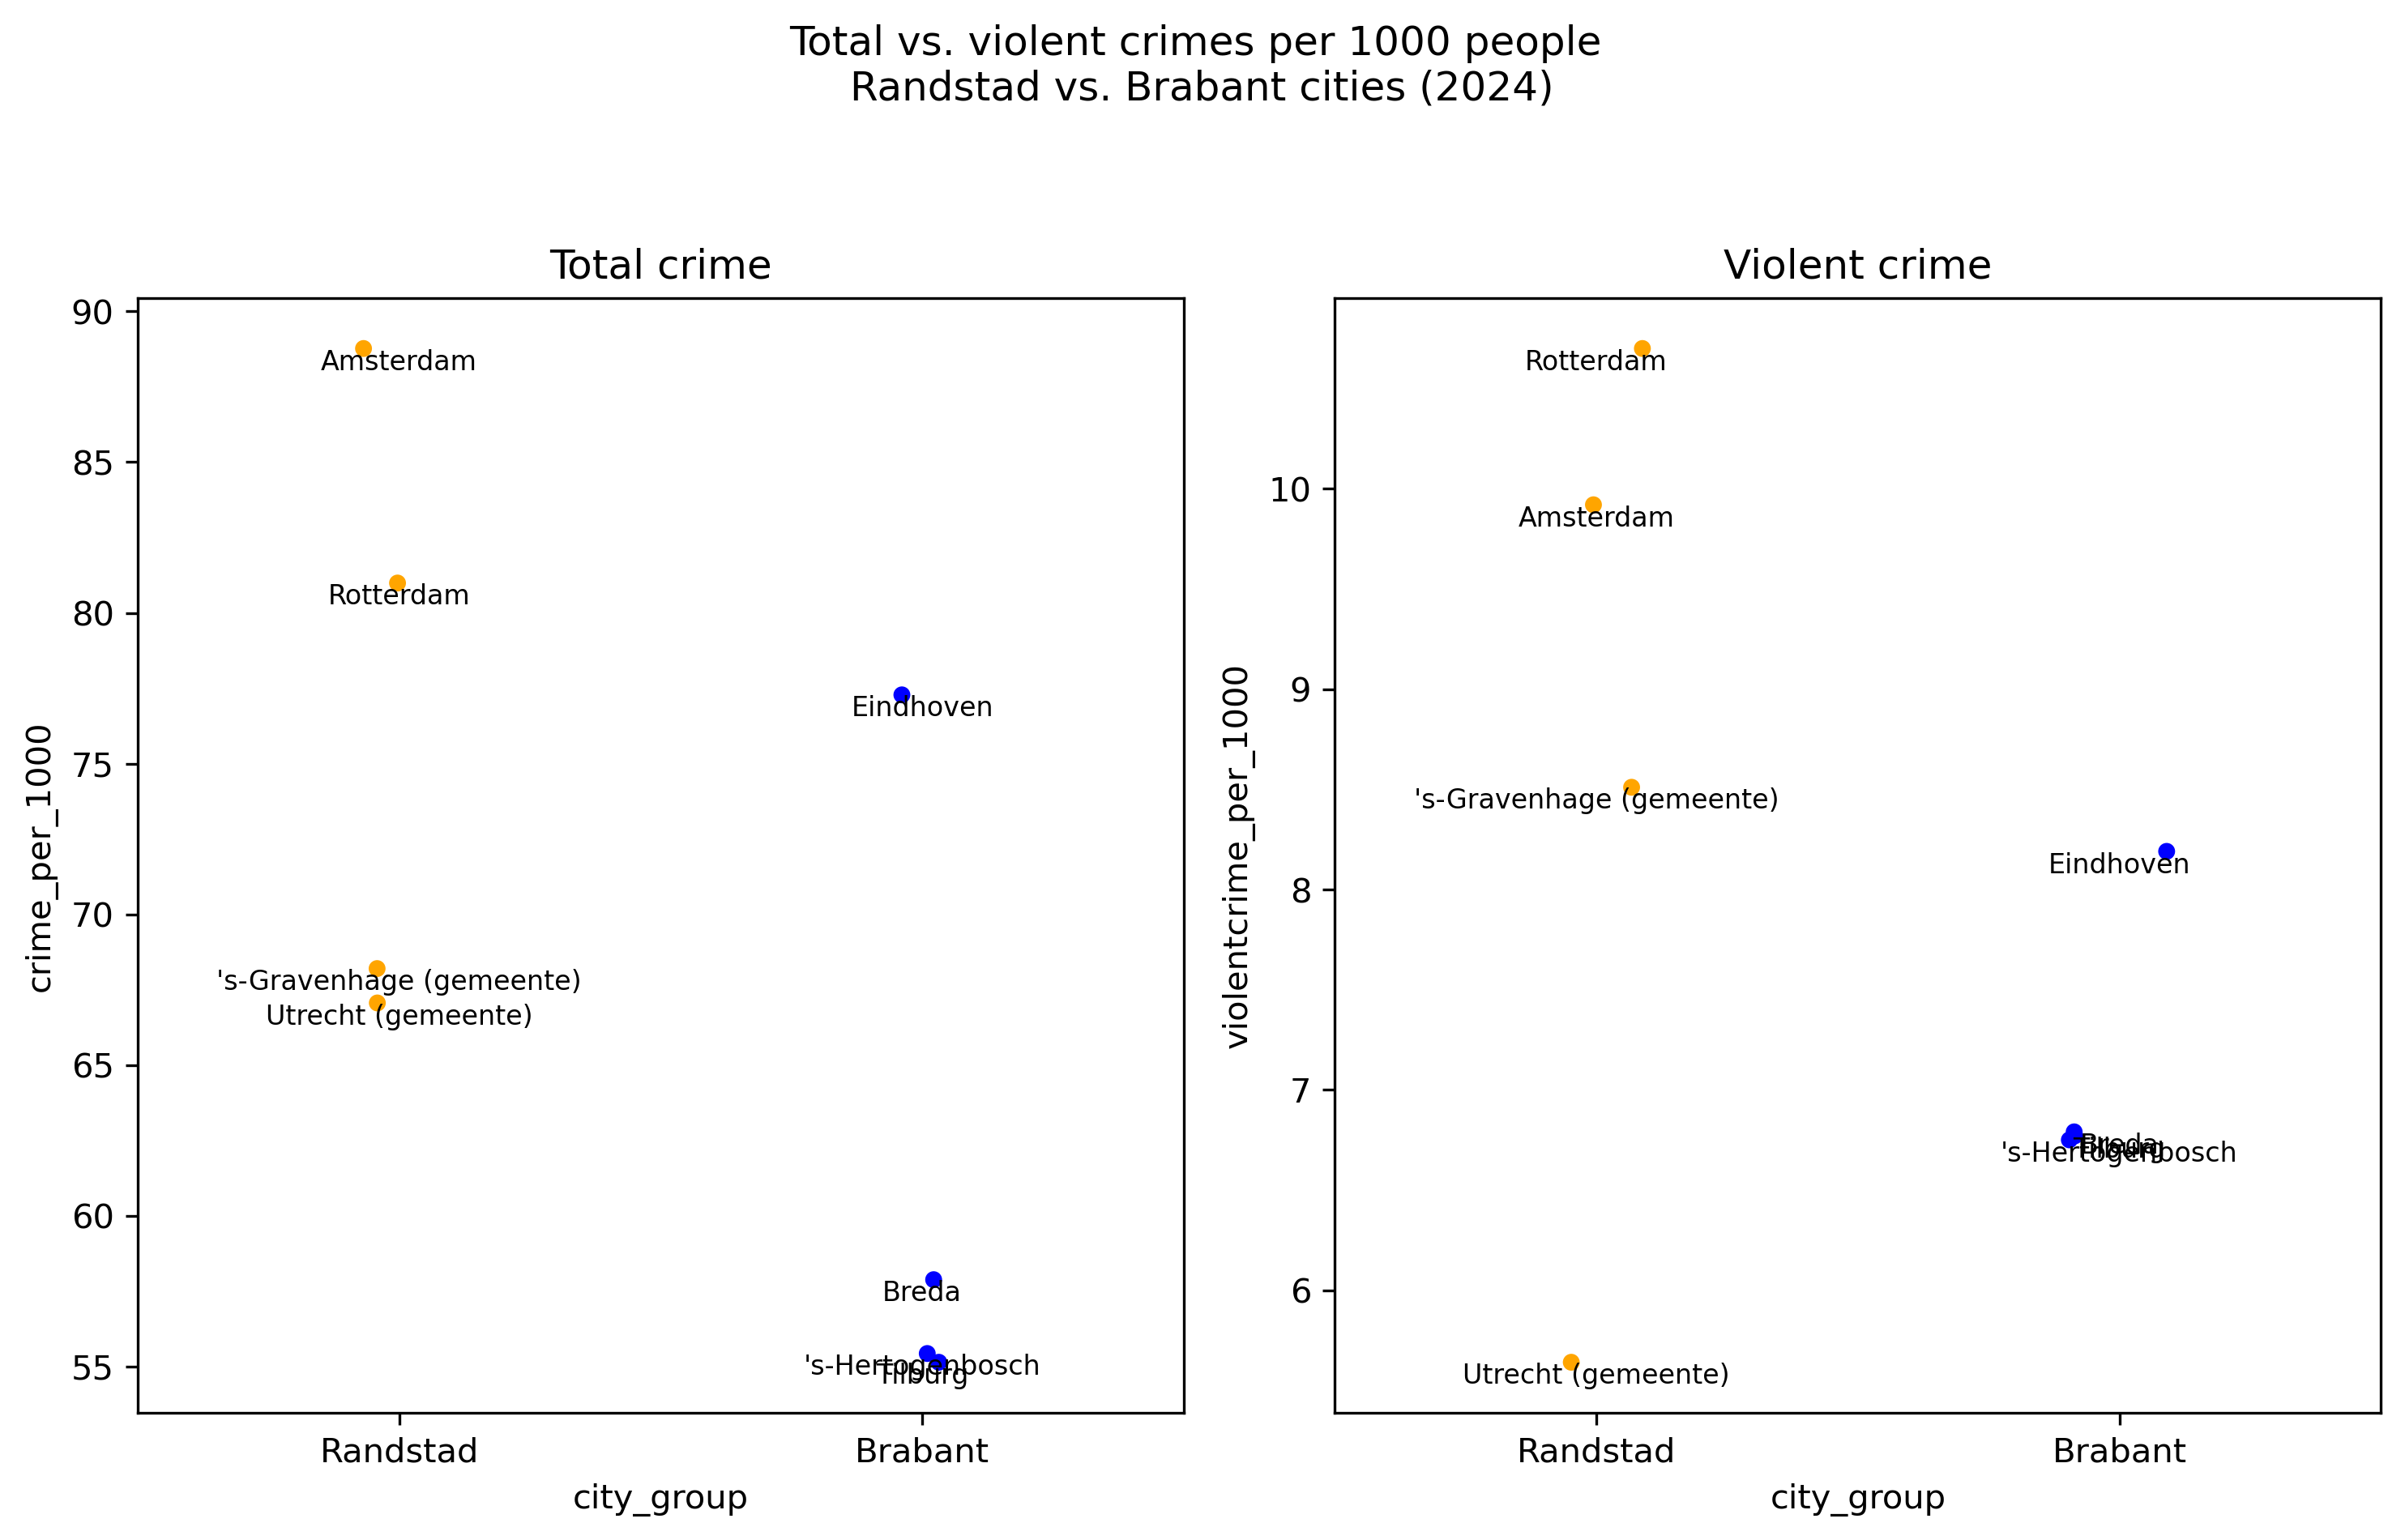

<b><i> Conclusions: </b></i>
The divergence in national vs. reigonal or local experiences perhaps contributes to the often contradictory picture of the status of Dutch crime portrayed in the media and by politics. While on a macro level it is true that we are overall better off in terms of crime rates than we were before, on the local level, some cities and regions are experiencing very real and worrying increases in crime. This likely contributes to opinions of whether enough is being done about crime diverging strongly based on one's local experience. Clearly, despite the national decreasing trend in crime, certain areas of the country are experiencing a much heavier burden of crime than they did pre-pandemic, particularly in large cities such as Rotterdam, Eindhoven and Groningen, which are experiencing both total and violent crime rates that are still above pre-pandemic levels.
This can have large consequences for the how the perception of crime influences people's consumption of media, their political opinions and their attitudes towards the society in which they live.

📊 See the full code, insights and visualisations below 👇


# Packages

In [793]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, math, re

%pip install scipy
%pip install scikit-learn
from scipy.stats import shapiro, probplot, spearmanr
from sklearn.preprocessing import StandardScaler

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data prep

Two different datasets are combined for this project in order to calculate both the total and violent crime rates relative to the population of each geogrpahic unit (national level, regional level and municipality/city level). 

<b>The data was prepared following the steps below:</b>
1) <b>Import and inspection of the data</b>
2) <b>Extracting and mapping metadata:</b> the crime data provided by Politie Nederlands uses numeric codes for each crime type, year and geographic measuresment. These codes first need to be extracted and mapped to their definitions in order to change the numeric codes in the dataset to meaningful names.
3) <b>Cleaning the data:</b> null values are idenitified in both datasets. After identifyin the proportion of null values for different features, the decision was made to remove any instances from both datasets with a null value, as null values in either the crime count or population features would jeopardize the ability to calculate crime per capita for that instance. While some null values could have been filled in, such as using interpolation based on a constant growth rate for the population data, this was avoided. Interpolating population based on a constant growth factor risks introducing large margins of error for downstream per capita crime calculations, given that demographic processes in the Netherlands are not constant, with some areas losing population rapidly while other areas grow rapidly. Crime values are much more variable and therefore difficult to interpolate accurately. Instead, null values were dropped to avoid introducing too much bias in the data.
4) <b>Calculating crime per 1000 people:</b> after extracting metadata and cleaning, the population and crime data were combined by joining the remaining instances with no null values based on region name and year and dividing the crime count for each crime category by the populatio/1000. Using crime per 1000 people rather than true crime per capita as many municipalities have several hundred thousand inhabitants and this makes the the final figures more interpretable for that scale.
5) <b>Creating crime, city and regional groupings:</b> Lists with names for crime and regional groupings of interest were created so they could be used later for grouping and iterating over the data. A violent crime category was created using crime types associated with physical force (i.e. zedendelicten (sex crimes), straatroof (mugging), etc. Additionally, serveral geographic categories were created, including a list for major cities in each region of the Netherlands and lists isolating the major cities in both the Randstad and Brabant.
6) <b>Defining functions:</b> functions were defined that would be needed in frequent calculations in the analysis, such as a percent change function that calculates the percent change in crime per 1000 between two inputted years.

## Import data

In [794]:
## Import crime data from Politie
## Data extracted from: https://data.politie.nl/portal.html?_la=nl&_catalog=Politie&tableId=47013NED&_theme=114
## On: 21-12-2025
crime_data = 'allemisdrijven_pvgm_21122025.csv'
crime_df = pd.read_csv(crime_data, sep=';')
## Import crime metada from Politie
metadata = 'allemisdrijven_metadata_21122025.csv'
metadata_df = pd.read_csv(metadata, sep=';', header=1)

## Import population data from CBS
## Data extracted from: https://opendata.cbs.nl/#/CBS/nl/dataset/37230ned/table?ts=1766338546563
## On: 21-12-2025
popdata = 'bevolkingeindeperiod_jaren_22122025.csv'
popdata_df = pd.read_csv(popdata, sep=';', header=3)

In [795]:
## Inspect metadata
metadata_df.head(20)

,ID,Title,ShortTitle,Identifier,Summary,Modified,ReasonDelivery,ExplanatoryText,Language,Catalog,...,Period,ShortDescription,Description,DefaultPresentation,DefaultSelection,GraphTypes,OutputStatus,Source,MetaDataModified,SearchPriority
0,0,Geregistreerde misdrijven en aangiften; soort ...,Misdrijven en aangiften per gemeente,47013NED,"Geregistreerde misdrijven, aangiften en intern...",2025-12-15T02:00:00,ActualiseringBijzonder,NaN,nl,Politie,...,2012-2025,\nDeze tabel bevat cijfers over het aantal ger...,INHOUDSOPGAVE\n\n1. Toelichting\n2. Definities...,ts=1764853734957&graphtype=Table&r=RegioS&k=To...,$filter=((SoortMisdrijf eq '0.0.0 ')) and ((Pe...,"Table,Bar,Map",Regulier,&copy; Politie,2025-12-15T02:00:00,2.0
1,DataProperties,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID,Position,ParentID,Type,Key,Title,Description,ReleasePolicy,Datatype,Unit,...,Default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,NaN,Dimension,SoortMisdrijf,Soort misdrijf,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,NaN,GeoDimension,RegioS,Regio's,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,2,NaN,TimeDimension,Perioden,Perioden,NaN,TRUE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,3,NaN,Topic,GeregistreerdeMisdrijven_1,Geregistreerde misdrijven,"Totaal van de geregistreerde misdrijven, bron ...",NaN,Long,aantal,...,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4,4,NaN,Topic,Aangiften_2,Aangiften,Aangiften betreffen geregistreerde misdrijven ...,NaN,Long,aantal,...,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5,5,NaN,Topic,Internetaangiften_3,Internetaangiften,Aangiften betreffen geregistreerde misdrijven ...,NaN,Long,aantal,...,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SoortMisdrijf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [796]:
## Only need the first two columns with codes and their values
metadata_sub = metadata_df.iloc[9:,:2]
metadata_sub

,ID,Title
9,SoortMisdrijf,NaN
10,Key,Title
11,0.0.0,Totaal misdrijven
12,1.1.1,1.1.1 Diefstal/inbraak woning
13,1.1.2,1.1.2 Diefstal/inbraak box/garage/schuur
...,...,...
624,2025MM07,2025 juli
625,2025MM08,2025 augustus
626,2025MM09,2025 september
627,2025MM10,2025 oktober


In [797]:
## Inspect crime data
crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1
0,12,0.0.0,NL01,2012JJ00,1127693.0
1,25,0.0.0,NL01,2013JJ00,1078652.0
2,38,0.0.0,NL01,2014JJ00,1002641.0
3,51,0.0.0,NL01,2015JJ00,961210.0
4,64,0.0.0,NL01,2016JJ00,914206.0
...,...,...,...,...,...
506923,3980515,3.9.3,GM0999,2025MM07,NaN
506924,3980516,3.9.3,GM0999,2025MM08,NaN
506925,3980517,3.9.3,GM0999,2025MM09,NaN
506926,3980518,3.9.3,GM0999,2025MM10,NaN


In [798]:
## Inspect population data
popdata_df

,Regio's,Onderwerp,Unnamed: 2,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Nederland,Bevolking aan het einde van de periode,aantal,16192572.0,16258032.0,16305526.0,16334210.0,16357992.0,16405399.0,16485787.0,...,16979120.0,17081507.0,17181084.0,17282163.0,17407585.0,17475415.0,17590672.0,17811291.0,17942942.0,18044027.0
1,Groningen (PV),Bevolking aan het einde van de periode,aantal,572997.0,574384.0,575072.0,574042.0,573614.0,573459.0,574092.0,...,583721.0,583581.0,582944.0,583990.0,585866.0,586937.0,590170.0,596075.0,601347.0,602833.0
2,Fryslân (PV),Bevolking aan het einde van de periode,aantal,639787.0,642066.0,642977.0,642230.0,642209.0,643189.0,644811.0,...,646040.0,646874.0,647268.0,647672.0,649957.0,651435.0,654019.0,659551.0,661904.0,664222.0
3,Drenthe (PV),Bevolking aan het einde van de periode,aantal,481254.0,482415.0,483369.0,484481.0,486197.0,488135.0,489918.0,...,488629.0,491792.0,492100.0,492167.0,493682.0,494771.0,497743.0,502051.0,504129.0,506529.0
4,Overijssel (PV),Bevolking aan het einde van de periode,aantal,1100677.0,1105512.0,1109432.0,1113529.0,1116374.0,1119994.0,1125435.0,...,1144280.0,1147687.0,1151501.0,1156431.0,1162406.0,1166533.0,1171910.0,1184333.0,1189033.0,1195789.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Zutphen,Bevolking aan het einde van de periode,aantal,36924.0,36552.0,36936.0,46642.0,46635.0,46762.0,46953.0,...,46997.0,47340.0,47537.0,47609.0,47934.0,48111.0,48330.0,48510.0,48752.0,49028.0
566,Zwartewaterland,Bevolking aan het einde van de periode,aantal,22206.0,22034.0,21877.0,21872.0,21919.0,21930.0,21944.0,...,22278.0,22309.0,22468.0,22503.0,22685.0,22823.0,23012.0,23368.0,23448.0,23507.0
567,Zwijndrecht,Bevolking aan het einde van de periode,aantal,41374.0,45384.0,45209.0,44588.0,44400.0,44472.0,44312.0,...,44454.0,44417.0,44586.0,44639.0,44737.0,44775.0,44789.0,45018.0,44874.0,44669.0
568,Zwolle,Bevolking aan het einde van de periode,aantal,109955.0,110880.0,111900.0,113078.0,114635.0,116365.0,117703.0,...,124896.0,125548.0,126116.0,127497.0,128840.0,129840.0,130668.0,132411.0,133141.0,133810.0


In [799]:
## Drop last row of population data, invalid
popdata_df = popdata_df[:-1]

## Drop onderwerp and unnamed columns, not needed
popdata_df = popdata_df.drop(columns=['Onderwerp', 'Unnamed: 2'])      

## Rename columns
popdata_df.rename(columns={"Regio's":"region"}, inplace=True)
popdata_df

,region,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Nederland,16192572.0,16258032.0,16305526.0,16334210.0,16357992.0,16405399.0,16485787.0,16574989.0,16655799.0,...,16979120.0,17081507.0,17181084.0,17282163.0,17407585.0,17475415.0,17590672.0,17811291.0,17942942.0,18044027.0
1,Groningen (PV),572997.0,574384.0,575072.0,574042.0,573614.0,573459.0,574092.0,576668.0,579036.0,...,583721.0,583581.0,582944.0,583990.0,585866.0,586937.0,590170.0,596075.0,601347.0,602833.0
2,Fryslân (PV),639787.0,642066.0,642977.0,642230.0,642209.0,643189.0,644811.0,646305.0,647282.0,...,646040.0,646874.0,647268.0,647672.0,649957.0,651435.0,654019.0,659551.0,661904.0,664222.0
3,Drenthe (PV),481254.0,482415.0,483369.0,484481.0,486197.0,488135.0,489918.0,490981.0,491411.0,...,488629.0,491792.0,492100.0,492167.0,493682.0,494771.0,497743.0,502051.0,504129.0,506529.0
4,Overijssel (PV),1100677.0,1105512.0,1109432.0,1113529.0,1116374.0,1119994.0,1125435.0,1130345.0,1134465.0,...,1144280.0,1147687.0,1151501.0,1156431.0,1162406.0,1166533.0,1171910.0,1184333.0,1189033.0,1195789.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Zundert,20386.0,20431.0,20554.0,20797.0,20849.0,20947.0,21083.0,21025.0,21163.0,...,21488.0,21657.0,21525.0,21612.0,21829.0,21988.0,22260.0,22518.0,22553.0,22809.0
565,Zutphen,36924.0,36552.0,36936.0,46642.0,46635.0,46762.0,46953.0,46870.0,47084.0,...,46997.0,47340.0,47537.0,47609.0,47934.0,48111.0,48330.0,48510.0,48752.0,49028.0
566,Zwartewaterland,22206.0,22034.0,21877.0,21872.0,21919.0,21930.0,21944.0,21935.0,22018.0,...,22278.0,22309.0,22468.0,22503.0,22685.0,22823.0,23012.0,23368.0,23448.0,23507.0
567,Zwijndrecht,41374.0,45384.0,45209.0,44588.0,44400.0,44472.0,44312.0,44404.0,44445.0,...,44454.0,44417.0,44586.0,44639.0,44737.0,44775.0,44789.0,45018.0,44874.0,44669.0


In [800]:
## Check columns and dtypes
print(crime_df.dtypes)
print('--------------')
print(popdata_df.dtypes)

ID                              int64
SoortMisdrijf                  object
RegioS                         object
Perioden                       object
GeregistreerdeMisdrijven_1    float64
dtype: object
--------------
region     object
2002      float64
2003      float64
2004      float64
2005      float64
2006      float64
2007      float64
2008      float64
2009      float64
2010      float64
2011      float64
2012      float64
2013      float64
2014      float64
2015      float64
2016      float64
2017      float64
2018      float64
2019      float64
2020      float64
2021      float64
2022      float64
2023      float64
2024      float64
dtype: object


## Extract crime metadata

In [801]:
## Check unique codes per crime, region and period
print('Unique crime codes:')
print(crime_df['SoortMisdrijf'].unique())
print('Unique gemeente codes:')
print(crime_df['RegioS'].unique())
print('Unique year codes:')
print(crime_df['Perioden'].unique())

Unique crime codes:
['0.0.0 ' '1.1.1 ' '1.1.2 ' '1.2.1 ' '1.2.2 ' '1.2.3 ' '1.2.4 ' '1.2.5 '
 '1.3.1 ' '1.4.1 ' '1.4.2 ' '1.4.3 ' '1.4.4 ' '1.4.5 ' '1.4.6 ' '1.4.7 '
 '1.5.2 ' '1.6.1 ' '1.6.2 ' '1.6.3 ' '2.1.1 ' '2.2.1 ' '2.4.1 ' '2.4.2 '
 '2.5.1 ' '2.5.2 ' '2.6.1 ' '2.6.2 ' '2.6.3 ' '2.6.4 ' '2.6.5 ' '2.6.7 '
 '2.6.8 ' '2.6.9 ' '2.6.10' '2.6.11' '2.6.12' '2.6.13' '2.6.14' '2.7.2 '
 '2.7.3 ' '3.1.1 ' '3.1.2 ' '3.1.3 ' '3.2.1 ' '3.2.2 ' '3.3.2 ' '3.3.5 '
 '3.4.2 ' '3.5.2 ' '3.5.5 ' '3.6.4 ' '3.7.1 ' '3.7.2 ' '3.7.3 ' '3.7.4 '
 '3.9.1 ' '3.9.2 ' '3.9.3 ']
Unique gemeente codes:
['NL01  ' 'PV20  ' 'PV21  ' 'PV22  ' 'PV23  ' 'PV24  ' 'PV25  ' 'PV26  '
 'PV27  ' 'PV28  ' 'PV29  ' 'PV30  ' 'PV31  ' 'PV99  ' 'GM1680' 'GM0358'
 'GM0197' 'GM0059' 'GM0482' 'GM0613' 'GM0361' 'GM0141' 'GM0034' 'GM0484'
 'GM1723' 'GM1959' 'GM0060' 'GM0307' 'GM0362' 'GM0363' 'GM0200' 'GM0202'
 'GM0106' 'GM0743' 'GM0744' 'GM0308' 'GM0489' 'GM0203' 'GM0888' 'GM1954'
 'GM0889' 'GM1945' 'GM1724' 'GM0893' 'GM0373' 'GM074

In [802]:
crime_codes = list(crime_df['SoortMisdrijf'].unique())
gemeente_codes = list(crime_df['RegioS'].unique())
year_codes = list(crime_df['Perioden'].unique())
## Combined all codes in one list for iteration
code_list = crime_codes + gemeente_codes + year_codes
code_list

['0.0.0 ',
 '1.1.1 ',
 '1.1.2 ',
 '1.2.1 ',
 '1.2.2 ',
 '1.2.3 ',
 '1.2.4 ',
 '1.2.5 ',
 '1.3.1 ',
 '1.4.1 ',
 '1.4.2 ',
 '1.4.3 ',
 '1.4.4 ',
 '1.4.5 ',
 '1.4.6 ',
 '1.4.7 ',
 '1.5.2 ',
 '1.6.1 ',
 '1.6.2 ',
 '1.6.3 ',
 '2.1.1 ',
 '2.2.1 ',
 '2.4.1 ',
 '2.4.2 ',
 '2.5.1 ',
 '2.5.2 ',
 '2.6.1 ',
 '2.6.2 ',
 '2.6.3 ',
 '2.6.4 ',
 '2.6.5 ',
 '2.6.7 ',
 '2.6.8 ',
 '2.6.9 ',
 '2.6.10',
 '2.6.11',
 '2.6.12',
 '2.6.13',
 '2.6.14',
 '2.7.2 ',
 '2.7.3 ',
 '3.1.1 ',
 '3.1.2 ',
 '3.1.3 ',
 '3.2.1 ',
 '3.2.2 ',
 '3.3.2 ',
 '3.3.5 ',
 '3.4.2 ',
 '3.5.2 ',
 '3.5.5 ',
 '3.6.4 ',
 '3.7.1 ',
 '3.7.2 ',
 '3.7.3 ',
 '3.7.4 ',
 '3.9.1 ',
 '3.9.2 ',
 '3.9.3 ',
 'NL01  ',
 'PV20  ',
 'PV21  ',
 'PV22  ',
 'PV23  ',
 'PV24  ',
 'PV25  ',
 'PV26  ',
 'PV27  ',
 'PV28  ',
 'PV29  ',
 'PV30  ',
 'PV31  ',
 'PV99  ',
 'GM1680',
 'GM0358',
 'GM0197',
 'GM0059',
 'GM0482',
 'GM0613',
 'GM0361',
 'GM0141',
 'GM0034',
 'GM0484',
 'GM1723',
 'GM1959',
 'GM0060',
 'GM0307',
 'GM0362',
 'GM0363',
 'GM0200',
 'GM0202',

In [803]:
## Create dictionary with each code and its meaning
metadata_ids = metadata_sub.loc[:,'ID']
metadata_titles = metadata_sub.loc[:,'Title']

codes_dict = {}

for i, t in zip(metadata_ids, metadata_titles):
    if i in code_list:
        codes_dict[i] = t
        
codes_dict

{'0.0.0 ': 'Totaal misdrijven',
 '1.1.1 ': '1.1.1 Diefstal/inbraak woning',
 '1.1.2 ': '1.1.2 Diefstal/inbraak box/garage/schuur',
 '1.2.1 ': '1.2.1 Diefstal uit/vanaf motorvoertuigen',
 '1.2.2 ': '1.2.2 Diefstal van motorvoertuigen',
 '1.2.3 ': '1.2.3 Diefstal van brom-, snor-, fietsen',
 '1.2.4 ': '1.2.4 Zakkenrollerij',
 '1.2.5 ': '1.2.5 Diefstal af/uit/van ov. voertuigen',
 '1.3.1 ': '1.3.1 Ongevallen (weg)',
 '1.4.1 ': '1.4.1 Zedendelicten',
 '1.4.2 ': '1.4.2 Moord, doodslag',
 '1.4.3 ': '1.4.3 Openlijk geweld (persoon)',
 '1.4.4 ': '1.4.4 Bedreiging',
 '1.4.5 ': '1.4.5 Mishandeling',
 '1.4.6 ': '1.4.6 Straatroof',
 '1.4.7 ': '1.4.7 Overval',
 '1.5.2 ': '1.5.2 Diefstallen (water)',
 '1.6.1 ': '1.6.1 Brand/ontploffing',
 '1.6.2 ': '1.6.2 Overige vermogensdelicten',
 '1.6.3 ': '1.6.3 Mensenhandel',
 '2.1.1 ': '2.1.1 Drugs/drankoverlast',
 '2.2.1 ': '2.2.1 Vernieling cq. zaakbeschadiging',
 '2.4.1 ': '2.4.1 Burengerucht (relatieproblemen)',
 '2.4.2 ': '2.4.2 Huisvredebreuk',
 '2.5.1 

In [804]:
## Replace all codes with their meanings in the crime data
crime_df = crime_df.map(lambda x: codes_dict.get(x,x))
crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1
0,12,Totaal misdrijven,Nederland,2012,1127693.0
1,25,Totaal misdrijven,Nederland,2013,1078652.0
2,38,Totaal misdrijven,Nederland,2014,1002641.0
3,51,Totaal misdrijven,Nederland,2015,961210.0
4,64,Totaal misdrijven,Nederland,2016,914206.0
...,...,...,...,...,...
506923,3980515,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 juli,NaN
506924,3980516,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 augustus,NaN
506925,3980517,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 september,NaN
506926,3980518,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 oktober,NaN


In [805]:
## Strip code numbers from crime names
new_values = []
for i in list(crime_df['SoortMisdrijf']):
    i = re.sub(r'\d.', '', i)
    new_values.append(i)

crime_df['SoortMisdrijf'] = new_values

crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1
0,12,Totaal misdrijven,Nederland,2012,1127693.0
1,25,Totaal misdrijven,Nederland,2013,1078652.0
2,38,Totaal misdrijven,Nederland,2014,1002641.0
3,51,Totaal misdrijven,Nederland,2015,961210.0
4,64,Totaal misdrijven,Nederland,2016,914206.0
...,...,...,...,...,...
506923,3980515,Fraude (overig),Gemeenten; niet in te delen,2025 juli,NaN
506924,3980516,Fraude (overig),Gemeenten; niet in te delen,2025 augustus,NaN
506925,3980517,Fraude (overig),Gemeenten; niet in te delen,2025 september,NaN
506926,3980518,Fraude (overig),Gemeenten; niet in te delen,2025 oktober,NaN


In [806]:
## Rename columns
crime_df.rename(columns={'ID':'id','SoortMisdrijf':'crime_type', 'RegioS':'region', 'Perioden':'year', 'GeregistreerdeMisdrijven_1':'crime_count'},
                inplace=True)

crime_df

,id,crime_type,region,year,crime_count
0,12,Totaal misdrijven,Nederland,2012,1127693.0
1,25,Totaal misdrijven,Nederland,2013,1078652.0
2,38,Totaal misdrijven,Nederland,2014,1002641.0
3,51,Totaal misdrijven,Nederland,2015,961210.0
4,64,Totaal misdrijven,Nederland,2016,914206.0
...,...,...,...,...,...
506923,3980515,Fraude (overig),Gemeenten; niet in te delen,2025 juli,NaN
506924,3980516,Fraude (overig),Gemeenten; niet in te delen,2025 augustus,NaN
506925,3980517,Fraude (overig),Gemeenten; niet in te delen,2025 september,NaN
506926,3980518,Fraude (overig),Gemeenten; niet in te delen,2025 oktober,NaN


In [807]:
## Drop ros with 2025 values; not comparable to previous full year data
crime_df = crime_df[~crime_df['year'].str.contains('2025')]
crime_df['year'].unique()

array(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', '2022', '2023', '2024'], dtype=object)

## Data quality & Cleaning 

### Crime data

In [808]:
## Check unique values after extracting metadata
print(crime_df['crime_type'].unique())
print('-------')
print(crime_df['region'].unique())

['Totaal misdrijven' 'Diefstal/inbraak woning'
 'Diefstal/inbraak box/garage/schuur' 'Diefstal uit/vanaf motorvoertuigen'
 'Diefstal van motorvoertuigen' 'Diefstal van brom-, snor-, fietsen'
 'Zakkenrollerij' 'Diefstal af/uit/van ov. voertuigen' 'Ongevallen (weg)'
 'Zedendelicten' 'Moord, doodslag' 'Openlijk geweld (persoon)'
 'Bedreiging' 'Mishandeling' 'Straatroof' 'Overval' 'Diefstallen (water)'
 'Brand/ontploffing' 'Overige vermogensdelicten' 'Mensenhandel'
 'Drugs/drankoverlast' 'Vernieling cq. zaakbeschadiging'
 'Burengerucht (relatieproblemen)' 'Huisvredebreuk'
 'Diefstal/inbraak bedrijven enz.' 'Winkeldiefstal'
 'Inrichting Wet Milieubeheer' 'Bodem' 'Water' 'Afval' 'Bouwstoffen'
 'Mest' 'Transport gevaarlijke stoffen' 'Vuurwerk' ' Bestrijdingsmiddelen'
 ' Natuur en landschap' ' Ruimtelijke ordening' ' Dieren'
 ' Voedselveiligheid' 'Bijzondere wetten' 'Leefbaarheid (overig)'
 'Drugshandel' 'Mensensmokkel' 'Wapenhandel' 'Kinderporno'
 'Kinderprostitutie' 'Onder invloed (lucht)' '

In [809]:
## Drop rows where region values are Buitenland, Gemeenten; niet in te delen or 'Niet in te delen (PV)'
region_bool = ['Buitenland', 'Gemeenten; niet in te delen', 'Niet in te delen (PV)']
crime_df = crime_df[~(crime_df['region'].isin(region_bool))]
## Check they were dropped
crime_df['region'].unique()

array(['Nederland', 'Groningen (PV)', 'Fryslân (PV)', 'Drenthe (PV)',
       'Overijssel (PV)', 'Flevoland (PV)', 'Gelderland (PV)',
       'Utrecht (PV)', 'Noord-Holland (PV)', 'Zuid-Holland (PV)',
       'Zeeland (PV)', 'Noord-Brabant (PV)', 'Limburg (PV)',
       'Aa en Hunze', 'Aalsmeer', 'Aalten', 'Achtkarspelen',
       'Alblasserdam', 'Albrandswaard', 'Alkmaar', 'Almelo', 'Almere',
       'Alphen aan den Rijn', 'Alphen-Chaam', 'Altena', 'Ameland',
       'Amersfoort', 'Amstelveen', 'Amsterdam', 'Apeldoorn', 'Arnhem',
       'Assen', 'Asten', 'Baarle-Nassau', 'Baarn', 'Barendrecht',
       'Barneveld', 'Beek (L.)', 'Beekdaelen', 'Beesel', 'Berg en Dal',
       'Bergeijk', 'Bergen (L.)', 'Bergen (NH.)', 'Bergen op Zoom',
       'Berkelland', 'Bernheze', 'Best', 'Beuningen', 'Beverwijk',
       'De Bilt', 'Bladel', 'Blaricum', 'Bloemendaal',
       'Bodegraven-Reeuwijk', 'Boekel', 'Borger-Odoorn', 'Borne',
       'Borsele', 'Boxtel', 'Breda', 'Bronckhorst', 'Brummen', 'Brunssum',
 

#### Null value handling
Crime count data is fundamental to the analysis and difficult to accurately interpolate due to strong yearly variation.

Therefore, any rows where the municipality/year combo does not have crime count data will be dropped.

In [810]:
## Check for null values
crime_df.isnull().sum()

id                  0
crime_type          0
region              0
year                0
crime_count    102642
dtype: int64

In [811]:
## Drop all rows where crime_count value is null; can't use in calculations and can't reliably interpolate
crime_df = crime_df[~crime_df['crime_count'].isnull()]
## Check it worked
crime_df.isnull().sum()

id             0
crime_type     0
region         0
year           0
crime_count    0
dtype: int64

In [812]:
## Covnert numeric columns to integer
dtypes_dict = {'year':'int','crime_count':'int'}
crime_df = crime_df.astype(dtypes_dict)

In [813]:
crime_df.dtypes

id              int64
crime_type     object
region         object
year            int64
crime_count     int64
dtype: object

### Population data

In [814]:
## Check df
print(popdata_df.head(20))
print(f"Total number of regions included: {popdata_df.shape[0]}")

                region        2002        2003        2004        2005  \
0            Nederland  16192572.0  16258032.0  16305526.0  16334210.0   
1       Groningen (PV)    572997.0    574384.0    575072.0    574042.0   
2         Fryslân (PV)    639787.0    642066.0    642977.0    642230.0   
3         Drenthe (PV)    481254.0    482415.0    483369.0    484481.0   
4      Overijssel (PV)   1100677.0   1105512.0   1109432.0   1113529.0   
5       Flevoland (PV)    351680.0    359904.0    365859.0    370656.0   
6      Gelderland (PV)   1960422.0   1966929.0   1972010.0   1975704.0   
7         Utrecht (PV)   1152218.0   1162258.0   1171291.0   1180039.0   
8   Noord-Holland (PV)   2573120.0   2587265.0   2599103.0   2606584.0   
9    Zuid-Holland (PV)   3439982.0   3451942.0   3458381.0   3458875.0   
10        Zeeland (PV)    378348.0    379028.0    379978.0    380186.0   
11  Noord-Brabant (PV)   2400198.0   2406994.0   2411359.0   2415946.0   
12        Limburg (PV)   1141889.0   1

#### Null value handling
271 municipalities have missing population data for at least one year. The national and regional level data does not have any missing population values.

Most municipalities with null population values have low total populations and therefore are unlikely to heavily skew crime figures. Furthermore, attempts to interpolate population with constant rates could backfire, as demographic trends in the Netherlands show sharply divering trends in population changes between urban and rural areas; while many urban areas are increasing in population, many smaller and rural municipalities are shrinking.

Therefore, it is more important to drop nulls and not interpolate to avoid introducingg too much variation and errors in crime per capita calculations.

In [815]:
## Check null values in population df

## Calculate percentage missing population data per row
nulls_per_row = (popdata_df.isnull().sum(axis=1) / popdata_df.shape[1])*100

print(nulls_per_row[nulls_per_row > 0]) 
                            
print(f"Most missing: {nulls_per_row.max()}")
print(f"Amount of rows with >= 25% missing: {len(nulls_per_row[nulls_per_row >= 25])}")



14     25.000000
17     75.000000
18     58.333333
22     66.666667
28     70.833333
         ...    
556    83.333333
558    62.500000
559    50.000000
562    25.000000
563    33.333333
Length: 271, dtype: float64
Most missing: 91.66666666666666
Amount of rows with >= 25% missing: 230


In [816]:
## Calculate number of null values per row as new column
popdata_calcs = popdata_df.copy()
popdata_calcs['n_nulls'] = popdata_calcs.isnull().sum(axis=1)
## Calculate average population over time per row as new column
popdata_calcs['avg_pop'] = popdata_calcs.loc[:,'2012':'2024'].mean(axis=1, skipna=True)
## Show rows with at least 1 missing population value
popdata_calcs[popdata_calcs['n_nulls'] > 0]

,region,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2017,2018,2019,2020,2021,2022,2023,2024,n_nulls,avg_pop
14,Aalburg,12087.0,12204.0,12164.0,12222.0,12293.0,12386.0,12556.0,12614.0,12685.0,...,13153.0,13321.0,NaN,NaN,NaN,NaN,NaN,NaN,6,13017.285714
17,Ter Aar,9080.0,9010.0,8999.0,8988.0,8964.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN
18,Abcoude,8595.0,8624.0,8603.0,8670.0,8651.0,8688.0,8680.0,8764.0,8791.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN
22,Alkemade,14428.0,14481.0,14501.0,14512.0,14536.0,14481.0,14628.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN
28,Altena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,55967.0,56352.0,57009.0,57726.0,58277.0,58726.0,17,57342.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,Zelhem,11214.0,11269.0,11295.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN
558,Zevenhuizen-Moerkapelle,10150.0,10198.0,10270.0,10325.0,10369.0,10314.0,10402.0,10531.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN
559,Zijpe,11314.0,11381.0,11484.0,11558.0,11558.0,11512.0,11566.0,11587.0,11577.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,11519.000000
562,Zuidhorn,18109.0,18150.0,18287.0,18459.0,18465.0,18374.0,18478.0,18568.0,18631.0,...,18917.0,19066.0,NaN,NaN,NaN,NaN,NaN,NaN,6,18834.714286


In [817]:
## Check patterns in average population for rows with at least one null value
print(popdata_calcs[popdata_calcs['n_nulls'] > 0][['region','avg_pop']])
print(f"Averge population of regions with at least one null value: {round(popdata_calcs[popdata_calcs['n_nulls'] > 0]['avg_pop'].mean(skipna=True),2)}")

                      region       avg_pop
14                   Aalburg  13017.285714
17                   Ter Aar           NaN
18                   Abcoude           NaN
22                  Alkemade           NaN
28                    Altena  57342.833333
..                       ...           ...
556                   Zelhem           NaN
558  Zevenhuizen-Moerkapelle           NaN
559                    Zijpe  11519.000000
562                 Zuidhorn  18834.714286
563                 Zuidplas  43675.692308

[271 rows x 2 columns]
Averge population of regions with at least one null value: 28212.46


In [818]:
## Drop all rows with at least one null value
print(f"Number of rows before dropping: {popdata_df.shape[0]}")
nullrow_counts = popdata_df.isnull().sum(axis=1)
nullrows_idx = list(nullrow_counts[nullrow_counts > 0].index)
popdata_df.drop(labels=nullrows_idx, axis=0, inplace=True)
print(f"Number of rows after dropping: {popdata_df.shape[0]}")


Number of rows before dropping: 569
Number of rows after dropping: 298


## Calculate crime rate per 1000 people

In [819]:
## Check df
crime_df.head()

,id,crime_type,region,year,crime_count
0,12,Totaal misdrijven,Nederland,2012,1127693
1,25,Totaal misdrijven,Nederland,2013,1078652
2,38,Totaal misdrijven,Nederland,2014,1002641
3,51,Totaal misdrijven,Nederland,2015,961210
4,64,Totaal misdrijven,Nederland,2016,914206


In [820]:
## Melt dataframe to match crime_df structure
popdata_long = pd.melt(
    popdata_df,
    id_vars=['region'],
    var_name='year',
    value_name='population'
)


In [821]:
popdata_long = popdata_long.astype({'year':'int','population':'int'})

popdata_long.head()

,region,year,population
0,Nederland,2002,16192572
1,Groningen (PV),2002,572997
2,Fryslân (PV),2002,639787
3,Drenthe (PV),2002,481254
4,Overijssel (PV),2002,1100677


In [822]:
## Check number of unique region names per dataframe
print(f"Number of unique regions in cleaned crime data: {crime_df['region'].nunique()}")
print(f"Number of unique regions in cleaned population data: {popdata_df['region'].nunique()}")

Number of unique regions in cleaned crime data: 355
Number of unique regions in cleaned population data: 298


In [823]:
## Merge crime and population dataframes by region and period
merged_df = crime_df.merge(popdata_long, on=['region','year'])
## Calculate misdrijven_per_cap column 
merged_df['crime_per_1000'] = round((merged_df['crime_count']/(merged_df['population']/1000)),2)
# merged_df.rename(columns={'population':'pop_per_1000'}, inplace=True)
# merged_df.head(50)
print(f"Final rows, columns: {merged_df.shape}")
print(f"Final number of regions included: {merged_df['region'].nunique()}")

Final rows, columns: (141796, 7)
Final number of regions included: 298


In [824]:
## Final data set with crime count, population and crime per 1000 people for each combination or region, year and crime type
merged_df.head()

,id,crime_type,region,year,crime_count,population,crime_per_1000
0,12,Totaal misdrijven,Nederland,2012,1127693,16779575,67.21
1,25,Totaal misdrijven,Nederland,2013,1078652,16829289,64.09
2,38,Totaal misdrijven,Nederland,2014,1002641,16900726,59.33
3,51,Totaal misdrijven,Nederland,2015,961210,16979120,56.61
4,64,Totaal misdrijven,Nederland,2016,914206,17081507,53.52


In [825]:
## Final check for remaining null values
merged_df.isnull().sum()

id                0
crime_type        0
region            0
year              0
crime_count       0
population        0
crime_per_1000    0
dtype: int64

## Create crime categories

In [826]:
## Check unique crime types
print(crime_df['crime_type'].unique())

['Totaal misdrijven' 'Diefstal/inbraak woning'
 'Diefstal/inbraak box/garage/schuur' 'Diefstal uit/vanaf motorvoertuigen'
 'Diefstal van motorvoertuigen' 'Diefstal van brom-, snor-, fietsen'
 'Zakkenrollerij' 'Diefstal af/uit/van ov. voertuigen' 'Ongevallen (weg)'
 'Zedendelicten' 'Moord, doodslag' 'Openlijk geweld (persoon)'
 'Bedreiging' 'Mishandeling' 'Straatroof' 'Overval' 'Diefstallen (water)'
 'Brand/ontploffing' 'Overige vermogensdelicten' 'Mensenhandel'
 'Drugs/drankoverlast' 'Vernieling cq. zaakbeschadiging'
 'Burengerucht (relatieproblemen)' 'Huisvredebreuk'
 'Diefstal/inbraak bedrijven enz.' 'Winkeldiefstal'
 'Inrichting Wet Milieubeheer' 'Bodem' 'Water' 'Afval' 'Bouwstoffen'
 'Mest' 'Transport gevaarlijke stoffen' 'Vuurwerk' ' Bestrijdingsmiddelen'
 ' Natuur en landschap' ' Ruimtelijke ordening' ' Dieren'
 ' Voedselveiligheid' 'Bijzondere wetten' 'Leefbaarheid (overig)'
 'Drugshandel' 'Mensensmokkel' 'Wapenhandel' 'Kinderporno'
 'Kinderprostitutie' 'Onder invloed (lucht)' '

In [827]:
total_crime =['Totaal misdrijven']

violent_crime = ['Zedendelicten','Moord, doodslag', 'Openlijk geweld (persoon)',
 'Bedreiging',
 'Mishandeling',
 'Straatroof',
 'Overval','Mensenhandel','Mensensmokkel', 'Kinderporno',
 'Kinderprostitutie', 'Wapenhandel']

explosive_crime = ['Brand/ontploffing', 'Vuurwerk']

env_crime = ['Inrichting Wet Milieubeheer', 'Bodem', 'Water', 'Afval', 'Bouwstoffen',
 'Mest', 'Transport gevaarlijke stoffen', 'Lucht (overig)',' Natuur en landschap', ' Dieren']

thievery = ['Diefstal/inbraak box/garage/schuur', 'Diefstal uit/vanaf motorvoertuigen', 'Diefstal van motorvoertuigen', 
'Diefstal van brom-, snor-, fietsen', 'Zakkenrollerij', 'Diefstal af/uit/van ov. voertuigen', 
'Diefstal/inbraak bedrijven enz.', 'Winkeldiefstal']

traffic = ['Ongevallen (weg)', 'Onder invloed (weg)', 'Weg (overig)' ]

## Create city & regional groupings

In [828]:
## Check gemeente names
crime_df['region'].unique()

array(['Nederland', 'Groningen (PV)', 'Fryslân (PV)', 'Drenthe (PV)',
       'Overijssel (PV)', 'Flevoland (PV)', 'Gelderland (PV)',
       'Utrecht (PV)', 'Noord-Holland (PV)', 'Zuid-Holland (PV)',
       'Zeeland (PV)', 'Noord-Brabant (PV)', 'Limburg (PV)',
       'Aa en Hunze', 'Aalsmeer', 'Aalten', 'Achtkarspelen',
       'Alblasserdam', 'Albrandswaard', 'Alkmaar', 'Almelo', 'Almere',
       'Alphen aan den Rijn', 'Alphen-Chaam', 'Altena', 'Ameland',
       'Amersfoort', 'Amstelveen', 'Amsterdam', 'Apeldoorn', 'Arnhem',
       'Assen', 'Asten', 'Baarle-Nassau', 'Baarn', 'Barendrecht',
       'Barneveld', 'Beek (L.)', 'Beekdaelen', 'Beesel', 'Berg en Dal',
       'Bergeijk', 'Bergen (L.)', 'Bergen (NH.)', 'Bergen op Zoom',
       'Berkelland', 'Bernheze', 'Best', 'Beuningen', 'Beverwijk',
       'De Bilt', 'Bladel', 'Blaricum', 'Bloemendaal',
       'Bodegraven-Reeuwijk', 'Boekel', 'Borger-Odoorn', 'Borne',
       'Borsele', 'Boxtel', 'Breda', 'Bronckhorst', 'Brummen', 'Brunssum',
 

In [829]:
## Create city groupings of interest for later analysis
brabant_cities = ['Eindhoven', 'Tilburg', 'Breda', "'s-Hertogenbosch"]
randstad_cities = ['Amsterdam', 'Utrecht (gemeente)', 'Rotterdam', "'s-Gravenhage (gemeente)"]
major_cities = ['Amsterdam', 'Haarlem', 'Utrecht (gemeente)', 'Rotterdam', "'s-Gravenhage (gemeente)", 
                   'Eindhoven', 'Tilburg', 'Breda', "'s-Hertogenbosch", 'Arnhem', 'Nijmegen', 'Groningen (gemeente)',
               'Maastricht', 'Enschede', 'Zwolle', 'Leeuwarden']

In [830]:
## Create separate dfs for different geographic levels (national, regions (PV) and gemeenten) for later analysis
## For total crime
regional_df = merged_df[(merged_df['region'].str.contains('(PV)')) & (merged_df['crime_type'] == 'Totaal misdrijven')]
national_df = merged_df[(merged_df['region'] == 'Nederland') & (merged_df['crime_type'] == 'Totaal misdrijven')]
cities_df = merged_df[((~merged_df['region'].isin(national_df['region'])) & (~merged_df['region'].isin(regional_df['region'])))
                        & (merged_df['crime_type'] == 'Totaal misdrijven')]

for i in [national_df, regional_df, cities_df]:
    i.drop(columns='id', inplace=True)
    i['crime_type'] = 'Total crime'
    i.reset_index(inplace=True)

## For violent crime
dfr = merged_df[(merged_df['region'].str.contains('(PV)')) & (merged_df['crime_type'].isin(violent_crime))]
dfn = merged_df[(merged_df['region'] == 'Nederland') & (merged_df['crime_type'].isin(violent_crime))]
dfc = merged_df[((~merged_df['region'].isin(national_df['region'])) & (~merged_df['region'].isin(regional_df['region'])))
                        & (merged_df['crime_type'].isin(violent_crime))]

vc_dfs = []
for i in [dfn, dfr, dfc]:
    i = i.groupby(by=['region','year']).sum()
    i = (i
    .drop(columns=['id','population'])
    .rename(columns={'crime_per_1000':'violentcrime_per_1000', 'crime_count':'violent_crime_count'})
        )
    i['crime_type'] = 'Violent crime'
    i.reset_index()
    vc_dfs.append(i)

national_violent = vc_dfs[0]
regional_violent = vc_dfs[1]
cities_violent = vc_dfs[2].reset_index()

C:\Users\chels\AppData\Local\Temp\ipykernel_31060\1819912324.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  regional_df = merged_df[(merged_df['region'].str.contains('(PV)')) & (merged_df['crime_type'] == 'Totaal misdrijven')]
C:\Users\chels\AppData\Local\Temp\ipykernel_31060\1819912324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.drop(columns='id', inplace=True)
C:\Users\chels\AppData\Local\Temp\ipykernel_31060\1819912324.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [831]:
## Check a total crime df example
regional_df

,index,crime_type,region,year,crime_count,population,crime_per_1000
0,13,Total crime,Groningen (PV),2012,35220,581705,60.55
1,14,Total crime,Groningen (PV),2013,33755,582728,57.93
2,15,Total crime,Groningen (PV),2014,30162,583942,51.65
3,16,Total crime,Groningen (PV),2015,29796,583721,51.04
4,17,Total crime,Groningen (PV),2016,29291,583581,50.19
...,...,...,...,...,...,...,...
151,164,Total crime,Limburg (PV),2020,50371,1115872,45.14
152,165,Total crime,Limburg (PV),2021,47907,1118302,42.84
153,166,Total crime,Limburg (PV),2022,52765,1128367,46.76
154,167,Total crime,Limburg (PV),2023,52426,1133255,46.26


In [832]:
## Check a violent crime df example
regional_violent

crime_type  violent_crime_count  \
region            year                                       
Drenthe (PV)      2012  Violent crime                 3342   
                  2013  Violent crime                 2999   
                  2014  Violent crime                 2889   
                  2015  Violent crime                 2599   
                  2016  Violent crime                 2343   
...                               ...                  ...   
Zuid-Holland (PV) 2020  Violent crime                24392   
                  2021  Violent crime                24140   
                  2022  Violent crime                24913   
                  2023  Violent crime                23055   
                  2024  Violent crime                23638   

                        violentcrime_per_1000  
region            year                         
Drenthe (PV)      2012                   6.82  
                  2013                   6.12  
                  2014                   5.92  
                  2015                   5.32  
                  2016                   4.76  
...                                       ...  
Zuid-Holland (PV) 2020                   6.55  
                  2021                   6.42  
                  2022                   6.57  
                  2023                   6.01  
                  2024                   6.12  

[156 rows x 3 columns]

## Define functions

In [833]:
## Define function to calculate percentage change for 2012-2024 and 2019-2024
def percent_change(group):
    calc2012 = group[group['year'] == 2012]['crime_per_1000'].values[0]
    calc2019 = group[group['year'] == 2019]['crime_per_1000'].values[0]
    calc2024 = group[group['year'] == 2024]['crime_per_1000'].values[0]

    ## New column for change 2012-2024
    pct_change_full = round((calc2024 - calc2012) / calc2012 * 100, 2)
    ## New column for change 2019-2024
    pct_change_recent = round((calc2024 - calc2019) / calc2019 * 100, 2)

    return pd.Series({
        'pct_change_full': pct_change_full,
        'pct_change_recent': pct_change_recent
    })

# 1) Has crime in the Netherlands actually been increasing?

One of the most important question in the minds of many who follow news and media in the Netherlands is: is crime actually increasing? 

It is true that societites everywhere, including the Netherlands, are experiencing upheaval and unrest. However, we also live in times of unprecedented access to up-to-the-minute news, which means information about crimes spreads far an wide, allowing for the appearance that crime is far more widespread and omnipresent than the reality. 

The plot below gives a clear answer to the question: in terms of total crime, including violent, financial, traffic, fraud and many others, <b><i>total crime in the Netherlands is unequivocally decreasing</b></i>, not increasing. In fact, total crime in the Netherlands has shown a steady and overall linear decline since 2012, with only small peaks of increase in 2019 and again in 2021 after the artificial decline of the pandemic. 

COVID allowed for a substantial decline in 2020 given its restriction of movement and public activity. However, even though total crime increased after 2020, it never surpassed it's pre-pandemic level and continued to slowly decline at a linear rate through 2024, albeit at a slower rate than seen in earlier years.

C:\Users\chels\anaconda3\Lib\site-packages\matplotlib\text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
C:\Users\chels\anaconda3\Lib\site-packages\matplotlib\text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


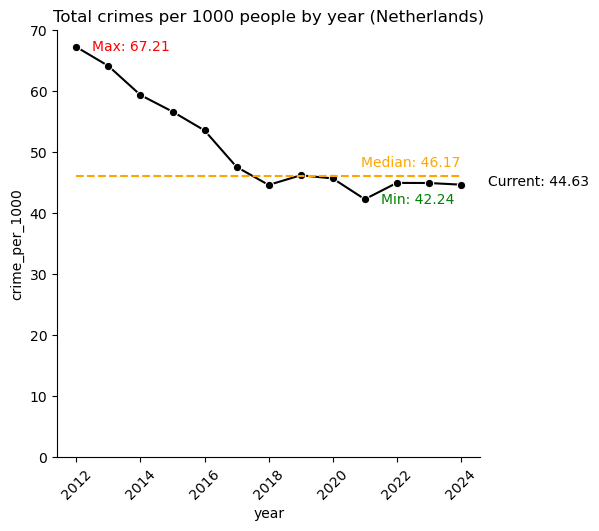

In [834]:
# Plot country-wide total crime per 1000
sns.relplot(
    data=national_df,
    x='year',
    y='crime_per_1000',
    marker='o',
    kind='line',
    color='black'
)

## Add median line
median_val = national_df['crime_per_1000'].median()
plt.hlines(y=round(median_val), xmin=2012, xmax=2024, colors='orange', linestyles='dashed', label='Median crime per 1000')

# Annotate min, max, median and current crime per 1000 values
min_val = national_df['crime_per_1000'].min()
max_val = national_df['crime_per_1000'].max()
current_val = national_df[national_df['year'] == 2024]['crime_per_1000'].values[0]

plt.text(
    x=national_df[national_df['crime_per_1000'] == min_val]['year'] + 0.5,  # Slightly offset for readability
    y=min_val,
    s=f'Min: {min_val:.2f}',
    ha='left',
    va='center',
    color='green'
)
plt.text(
    x= national_df[national_df['crime_per_1000'] == max_val]['year'] + 0.5,  # Slightly offset for readability
    y=max_val,
    s=f'Max: {max_val:.2f}',
    ha='left',
    va='center',
    color='red'
)
plt.text(
    x=2024,  # Place at the end of the x-axis
    y=median_val + 2, ## offset for readabililty
    s=f'Median: {median_val:.2f}',
    ha='right',
    va='center',
    color='orange'
)
plt.text(
    x=2028,  # Place at the end of the x-axis
    y=current_val + 0.5, ## offset for readabililty
    s=f'Current: {current_val:.2f}',
    ha='right',
    va='center',
    color='black'
)

plt.title('Total crimes per 1000 people by year (Netherlands)')
plt.xticks(rotation=45)
plt.ylim(0,70)

## Export figure
plt.savefig("totalcrime_line_national.png", dpi=300, bbox_inches="tight")
plt.show()


Looking at the <b><i>distribution of total crime across all municipalities in the Netherlands</b></i> at both the end and the beginning of the surveyed period reinforces this trend. 

The histograms below show how the distirbution of total crime across Dutch municipalities has shifted from 2012 to 2024. The distribution has increasingly skewed towards lower total crime rates across municipalities, with the median total crime rate decreasing from approximately 50 in 2012 to approximately 30 in 2024.

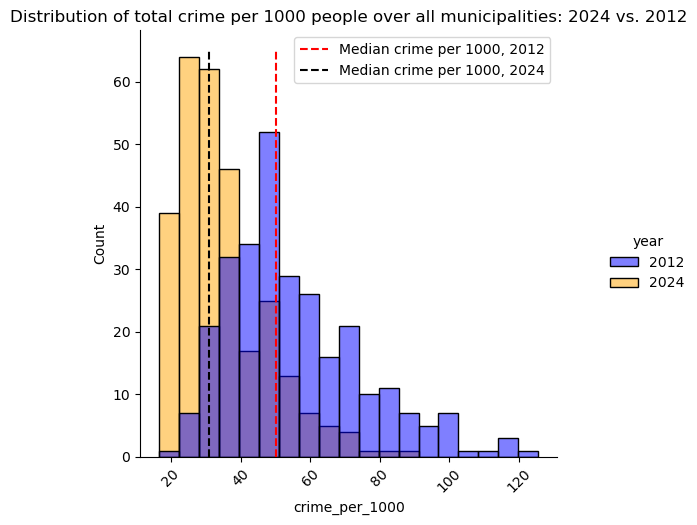

In [835]:
# Find the 10 cities with the highest crime in 2024 and in 2012
cities_compare = cities_df[ ((cities_df['year'] == 2024) | (cities_df['year'] == 2012)) ].sort_values(
    by=['crime_per_1000'], ascending=False)

# Histogram of distribution of total crime figures per gemeente in 2024 and 2012
sns.displot(data=cities_compare, x='crime_per_1000', hue='year', kind="hist", palette=['blue','orange'])

## Create median lines for each year's distribution
plt.vlines(x=cities_compare[cities_compare['year']==2012]['crime_per_1000'].median(), ymin=0, ymax=65, 
           colors='red', linestyles='dashed', label='Median crime per 1000, 2012')
plt.vlines(x=cities_compare[cities_compare['year']==2024]['crime_per_1000'].median(), ymin=0, ymax=65, 
           colors='black', linestyles='dashed', label='Median crime per 1000, 2024')

plt.legend()

plt.title('Distribution of total crime per 1000 people over all municipalities: 2024 vs. 2012')
plt.xticks(rotation=45)
plt.show()

# 2) Do violent v. total crime rates differ over time?

On the national scale, <b><i>violent crime rates have also steadily decreased from 2012 to 2024 in the Netherlands</b></i>, as shown in the plots below. 

However, while total crime rates have decreased precipitously, from roughly 70 crimes per 100 people in 2012 nationally to roughly 45 crimes per 1000 people in 2024, violent crime rates have decreased much more slowly while still remaning overall very low in comparison to total crime rates. 

Violent crime per 1000 people on the national level was already only about 10 per 1000 people in 2012 and has now decreased to about 7 per 1000 people as of 2024.

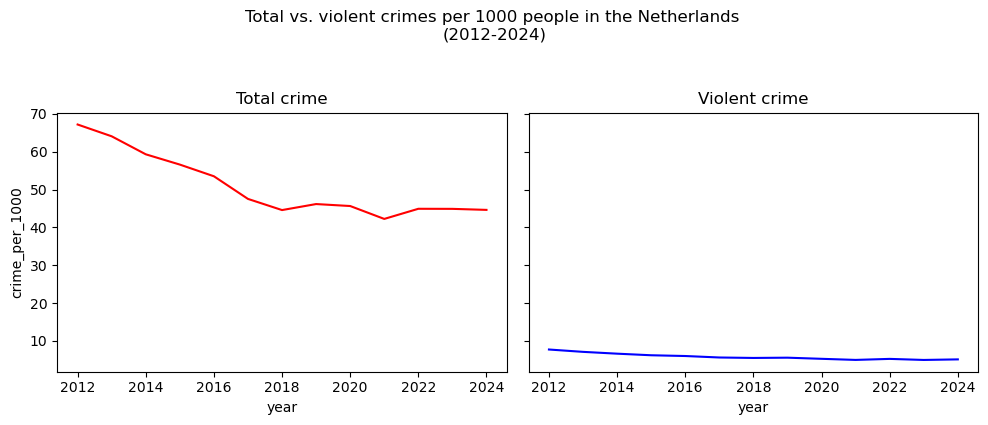

In [836]:
## Plot line chart of national violent crime rate 2012-2024; compare to national total crime rate 2012-2024

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharey=True, sharex=True)


## Plot national total crimes progression
sns.lineplot(data=national_df, 
             x='year', y='crime_per_1000', color='red',
             ax=axs[0],
            legend=False)

## Plot national violent crime progression
sns.lineplot(data=national_violent, 
             x='year', y='violentcrime_per_1000', color='blue',  
             ax=axs[1])

# Set titles
f.suptitle('Total vs. violent crimes per 1000 people in the Netherlands \n(2012-2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')
## Export figure
plt.savefig("totalvviolent_line_national.png", dpi=300, bbox_inches="tight")


f.tight_layout()
plt.show()

# 3) Which regions have the highest overall and violent crime rates?

The trends for crime rates by region differ from those seen on the national aggregate level. The trend lines show in the line plots below show considerably more year on year variation, rather than the relatively steady decreasing trend line seen for both overall and violent crime rates on the national level over the same period. They also present <b><i>an interesting counterpoint to the steadily decreasing trend of total crime rate that we saw on the national level: while it is true that, viewed from the national level, total crime is steadily decreasing, not all regions experience it this way.</b></i>

Some regions show a recent sharply increasing trend since 2022 in total crime rate per 1000 people within their borders, notably Noord Holland, Zuid Holland, Limburg and Groningen. Meanwhile, both Drenthe and Fryslan have both the lowest historic total crime rates as well the steadily decreasing recent rates.

The regional trends for violent crime rates, however, closely match those on the national level over the same period, with a slowly, but steadily, decreasing trend since 2012 for all regions. While Noord Holland and Zuid Holland are closely matched for the highest violent crime rate of the regions, both historically and more recently, thei rates do not differ substantially from the average.

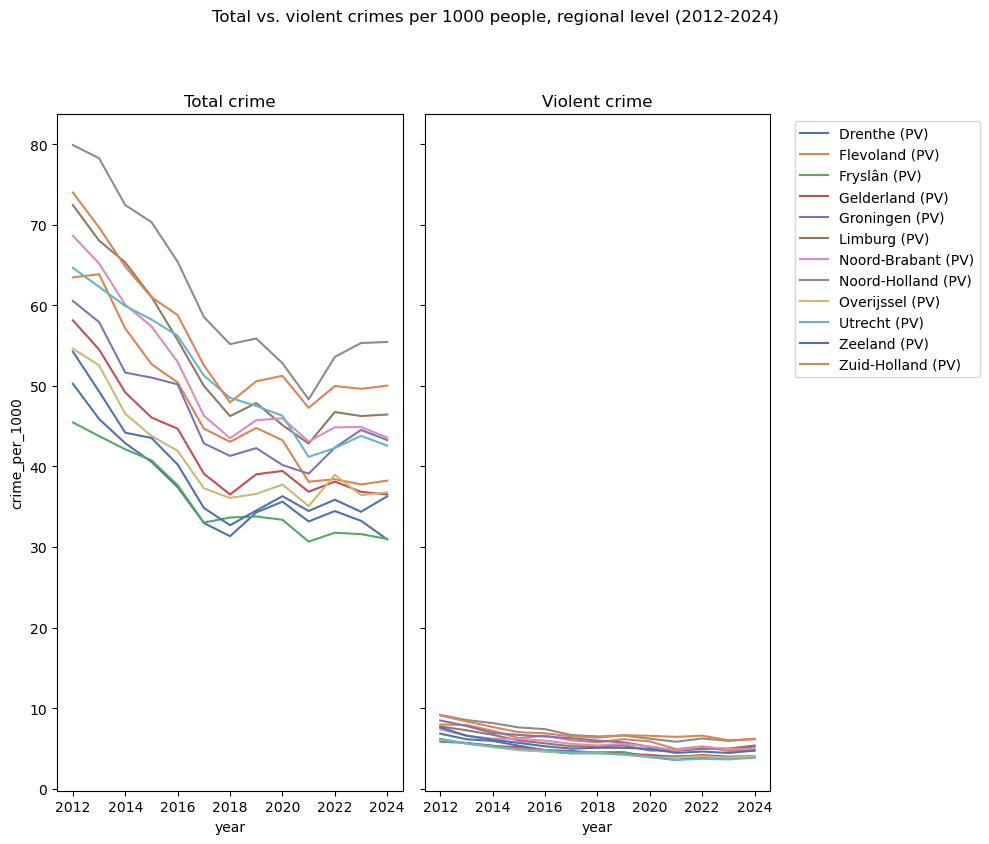

In [837]:
## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw=dict(width_ratios=[4, 4]), sharey=True, sharex=True)


# Extract the deep palette
deep_palette = sns.color_palette("deep")

# Get unique regions and assign a consistent color
unique_regions = sorted(regional_df['region'].unique())
region_color_map = {region: deep_palette[i % len(deep_palette)] for i, region in enumerate(unique_regions)}

# Convert the dictionary to a list in the correct order for seaborn
palette = [region_color_map[region] for region in unique_regions]

## Plot national total crimes progression
sns.lineplot(data=regional_df, 
             x='year', y='crime_per_1000',
             hue='region',
             ax=axs[0], palette=palette, hue_order=unique_regions,
            legend=False)

## Plot national violent crime progression
sns.lineplot(data=regional_violent, 
             x='year', y='violentcrime_per_1000',
             hue='region', palette=palette, hue_order=unique_regions,
             ax=axs[1])

# Set titles
f.suptitle('Total vs. violent crimes per 1000 people, regional level (2012-2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')

# Move legend outside plots
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

f.tight_layout()

### Percent changes over time

Another way to view regional trends in total crime rates is to view the total percent change for the most recent year (2024) compared to previous years. The table below shows the percent change relative to the beginning of the data period (2012) and compared to the last pre-pandemic year (2019).

This information presents a complementary picture to the graphs above. For example, although the trend lines for Noord and Zuid Holland show that they have historically had the highest total crimes rates and some of the most steeply increasing rates in the last decade, others regions show sharper increases relative to their pre-pandemic levels. 

<b><i>Zeeland, Overijssel and Groningen are the only regions that still show an increase in total crime rates relative to their pre-pandemic levels</b></i>. In contrast, all other regions, including Noord and Zuid Holland, actually show a decrease relative to their pre-pandemic levels, albeit relatively small in some cases.

In [838]:
## Apply percent_change function to regional data
regions_pctchange = (
    regional_df[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)

## Rename columns
regions_pctchange.rename(columns={'pct_change_full':'% change total crime 2012-2024', 'pct_change_recent':'% change total crime 2019-2024'}, inplace=True)
regions_pctchange.sort_values(by='% change total crime 2019-2024', ascending=False)

C:\Users\chels\AppData\Local\Temp\ipykernel_31060\1900282419.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)


,region,% change total crime 2012-2024,% change total crime 2019-2024
10,Zeeland (PV),-33.13,5.10
4,Groningen (PV),-28.52,2.37
8,Overijssel (PV),-32.66,0.55
7,Noord-Holland (PV),-30.60,-0.77
11,Zuid-Holland (PV),-32.40,-1.09
5,Limburg (PV),-35.90,-2.99
6,Noord-Brabant (PV),-36.50,-4.72
3,Gelderland (PV),-37.18,-6.41
2,Fryslân (PV),-31.82,-8.26
0,Drenthe (PV),-38.45,-9.77


### In 2024

The current status of regional crime rates shows an interesting divergence between overall and violent crime rates. The table below, ordered by total crime rates in descending order, again clearly shows that Noord Holland, Zuid Holland and Limburg come out on top in terms of both total and violent crime rates, while Fryslan and Drenthe are among the lowest. 

However, <b><i>while for most regions their rank in terms of violent crime rate tracks their rank in total crime, the Utrecht regions bucks this trend</b></i>. 

Although Utrecht ranks 6th in total crime rate for 2024 out of 12 regions, it has the lowest violent crime rate of all 12, even lower than Fryslan or Drenthe, despite their much lower total crime rates. In fact, while Utrecht's total crime rate is only 8-12 points lower than the Noord Holland or Zuid Holland, their violent crime rate is almost half that of the same two regions. 

The same data can analyzed visually using the grouped barplot below.

In [839]:
regional_grouped = regional_df.groupby(by=['region','year']).sum()
regional_concat = pd.concat([regional_grouped[['crime_per_1000']], regional_violent[['violentcrime_per_1000']]], axis=1)
regional_2024 = regional_concat.xs(2024, level='year')
regional_2024['year'] = 2024
regional_2024.sort_values(by='violentcrime_per_1000', ascending=False). reset_index()

C:\Users\chels\AppData\Local\Temp\ipykernel_31060\3340846202.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regional_2024['year'] = 2024


,region,crime_per_1000,violentcrime_per_1000,year
0,Noord-Holland (PV),55.46,6.17,2024
1,Zuid-Holland (PV),50.03,6.12,2024
2,Limburg (PV),46.45,5.35,2024
3,Groningen (PV),43.28,5.22,2024
4,Noord-Brabant (PV),43.59,4.92,2024
5,Flevoland (PV),38.24,4.73,2024
6,Zeeland (PV),36.29,4.72,2024
7,Gelderland (PV),36.53,4.03,2024
8,Overijssel (PV),36.79,4.02,2024
9,Drenthe (PV),30.94,3.93,2024


C:\Users\chels\AppData\Local\Temp\ipykernel_31060\2974048797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regional_2024.drop(columns='year', inplace=True)


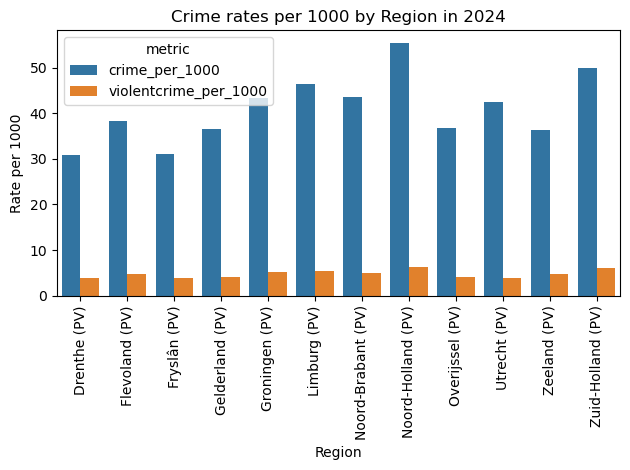

In [840]:
## Melt the data to long format
regional_2024.drop(columns='year', inplace=True)
regional2024_long = pd.melt(
    regional_2024.reset_index(),
    id_vars='region',  # Column to keep as is
    var_name='metric',  # New column for the melted variable names
    value_name='values' # New column for the melted values
)

## Plot 2024 total and violent crime rates per region
sns.barplot(data=regional2024_long, x='region', y='values', hue='metric')

plt.title("Crime rates per 1000 by Region in 2024")
plt.xlabel("Region")
plt.ylabel("Rate per 1000")
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()

# 4) Which cities have historically had and currently have the highest crime rates?

Cities show similar trends to that of regions, in that despite the national trend showing a steady decrease, many cities are experiencing a relative increase in total crime rates, especially compared to their pre-pandemic levels.

## Over time

The table below shows the major cities of the Netherlands, manually selected based on their notoriety and regional importance, and how their average total crime rates compare to each other over the period 2012-2024.

In [841]:
# Find the top 20 cities with the highest overall average crime per 1000 people over time
mjcities_total = cities_df[cities_df['region'].isin(major_cities)]

mjcities_grouped = mjcities_total[['region','crime_per_1000']].groupby(by=['region']).mean().sort_values(
    by=['crime_per_1000'], axis=0, ascending=False).round(2)
mjcities_grouped.rename(columns={'crime_per_1000':'Avg. total crime per 1000; 2012-2024'}, inplace=True)
## How can I rename the column to make clear they are averaged values??

mjcities_grouped

,Avg. total crime per 1000; 2012-2024
region,
Amsterdam,99.14
Rotterdam,87.59
Eindhoven,85.52
Utrecht (gemeente),79.04
Maastricht,77.98
's-Gravenhage (gemeente),76.94
Arnhem,75.89
Nijmegen,72.02
Groningen (gemeente),71.53


### Total crime progression over time: 2012 -2024

The plots below contrast the steadily decreasing national total crime rate trend on the left with the sharp recent increases in total crime rate experiences by many of the Netherlands' major cities post-pandemic.

<b><i>Amsterdam, Rotterdam, Eindhoven and Groningen show particularly sharp increases in total crime rates since 2021. Groningen, Rotterdam and Den Haag are still experiencing total crime rates above pre-pandemic levels. </b></i>

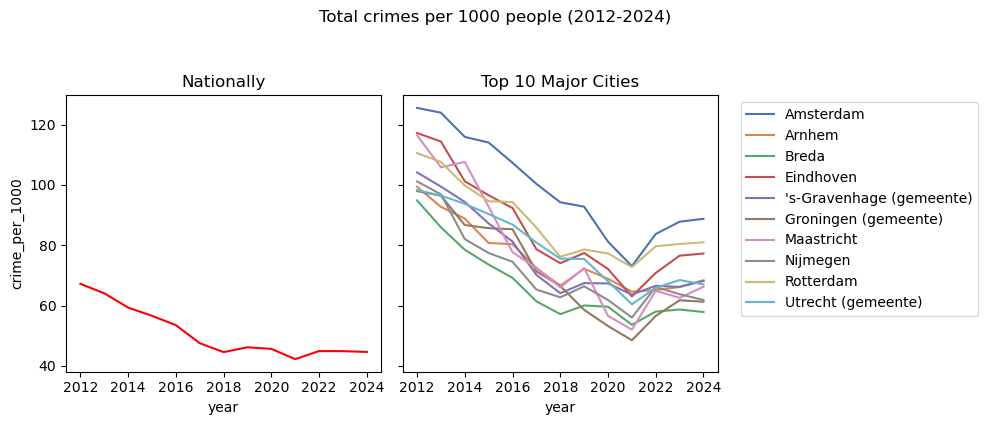

In [842]:
##Plot national & city trends from 2012 - 2024

## Subset top 10 cities in terms of historic average total crime rates per 1000 people
top10_gemeenten = cities_df[(cities_df['region'].isin(mjcities_grouped.index[:10]))]

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharey=True, sharex=True)


## Plot full timeline country level
sns.lineplot(data=national_df, 
             x='year', y='crime_per_1000', 
             color='red', 
             ax=axs[0],
            legend=False)

## Plot full timeline top 100 gemeenten
sns.lineplot(data=top10_gemeenten, 
             x='year', y='crime_per_1000', 
             hue='region', palette='deep',
             ax=axs[1])

# Set titles
f.suptitle('Total crimes per 1000 people (2012-2024)', y=1.05)
axs[0].set_title('Nationally')
axs[1].set_title('Top 10 Major Cities')

# Move legend outside plots
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
## Export figure
plt.savefig("totalcrime_line_nationalvcities.png", dpi=300, bbox_inches="tight")

f.tight_layout()
plt.show()

### Total crime progression over time: post-pandemic

The plots below show the same trends as before, but zoomed in on the years surrounding the pandemic (2019-2024

The sharply increasing trends for total crime in Amsterdam, Rotterdam and Eindhoven become even clearer, in contrast to the steady dip on the national level.

<b><i>With this zoomed in view, the trend lines for both Groningen and Maastricht also show steeply increasing trend lines for total crime rate since 2021.</b></i>

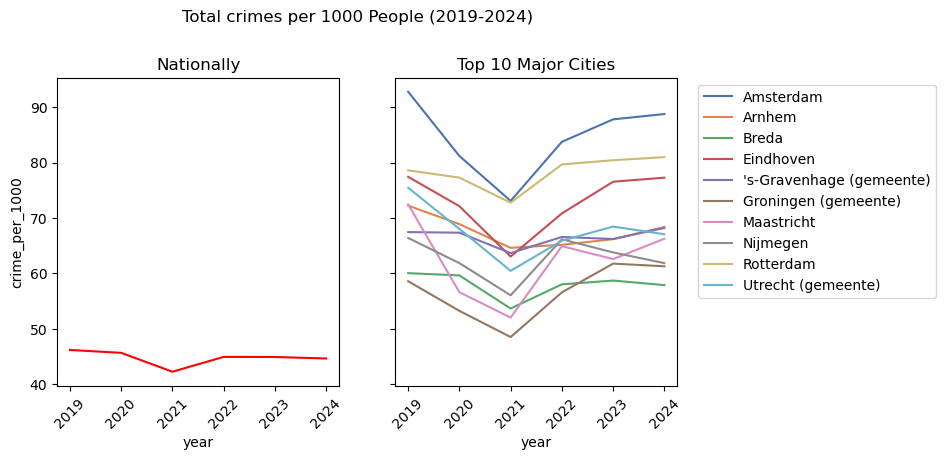

In [843]:
## Plot national & city trends from 2019-2024
last5_boolmask = range(2019,2025)

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True, sharey=True)

## Plot country wide total crime 2019-2024
sns.lineplot(data=national_df[national_df['year'].isin(last5_boolmask)], 
             x='year', y='crime_per_1000', 
             color='red',
             ax=axs[0],
            legend=False)


## Plot top 10 gemeenten 2019-2024
sns.lineplot(data=top10_gemeenten[top10_gemeenten['year'].isin(last5_boolmask)], 
             x='year', y='crime_per_1000', 
             hue='region', palette='deep',
             ax=axs[1])

# Set titles
f.suptitle('Total crimes per 1000 People (2019-2024)', y=1.05)
axs[0].set_title('Nationally')
axs[1].set_title('Top 10 Major Cities')

## Rotate all x tick labels
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

# Move legend outside plots
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


f.tight_layout
## Export figure
plt.savefig("totalcrime_line_nationalvcities_20192024.png", dpi=300, bbox_inches="tight")
plt.show()


The table below shows the percentage change in total crime rate in 2024 relative to both 2012 and 2019 for each of the major cities examined.

Relative to pre-pandemic levels (2019), most cities have still shown a decreased in total crime rates. 

<b><i>Only Groningen, Rotterdam and Den Haag show elevated total crime rates compared to pre-pandemic levels.</b></i>

In [844]:
## Create table with percentage changes in total crime for whole country + selected 10 cities over differnt time periods

## Apply the function to national data
country_pctchange = (
    national_df[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)

## Apply percent_change function to top 10 major cities data
top10_pctchange = (
    top10_gemeenten[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)

## Concat both into new dataframe
compare_pctchange = pd.concat([country_pctchange, top10_pctchange], axis=0).sort_values(by='pct_change_recent', ascending=False)
compare_pctchange.rename(columns={'pct_change_full':'total crime % change 2012-2024', 'pct_change_recent':'total crime % change 2019-2024'}, inplace=True)
compare_pctchange

C:\Users\chels\AppData\Local\Temp\ipykernel_31060\3349679363.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)
C:\Users\chels\AppData\Local\Temp\ipykernel_31060\3349679363.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)


,region,total crime % change 2012-2024,total crime % change 2019-2024
5,Groningen (gemeente),-37.44,4.61
8,Rotterdam,-26.75,3.04
0,'s-Gravenhage (gemeente),-34.52,1.11
4,Eindhoven,-34.08,-0.19
0,Nederland,-33.60,-3.34
3,Breda,-39.00,-3.60
1,Amsterdam,-29.30,-4.34
2,Arnhem,-31.20,-5.33
7,Nijmegen,-38.87,-6.84
6,Maastricht,-43.12,-8.56


### Total v. violent crime over time

The plots below compare the trends in total crime rates vs. violent crime rates for the major cities from 2012-2024.

Luckily, many cities show both overall and recent reductions in violent crime rates per 1000 people. However, once again, some cities are experiencing increasing levels post-pandemic. 

One immediately noticeable pattern is that the year to year violent crime rates per city vary much more than the year to year total crime rates, as seen by more jagged trend lines for violent crime rates compared to the smoother trend lines for total crime rates.

The relative ranking of cities also changes when looking at violent crime rates compared to total crime rates. 

<b><i>While Amsterdam, Rotterdam, Eindhoven show the highest recent total crime rates, Rotterdam tops the list in recent violent crime rates, followed by Amsterdam and then Den Haag.</b></i>

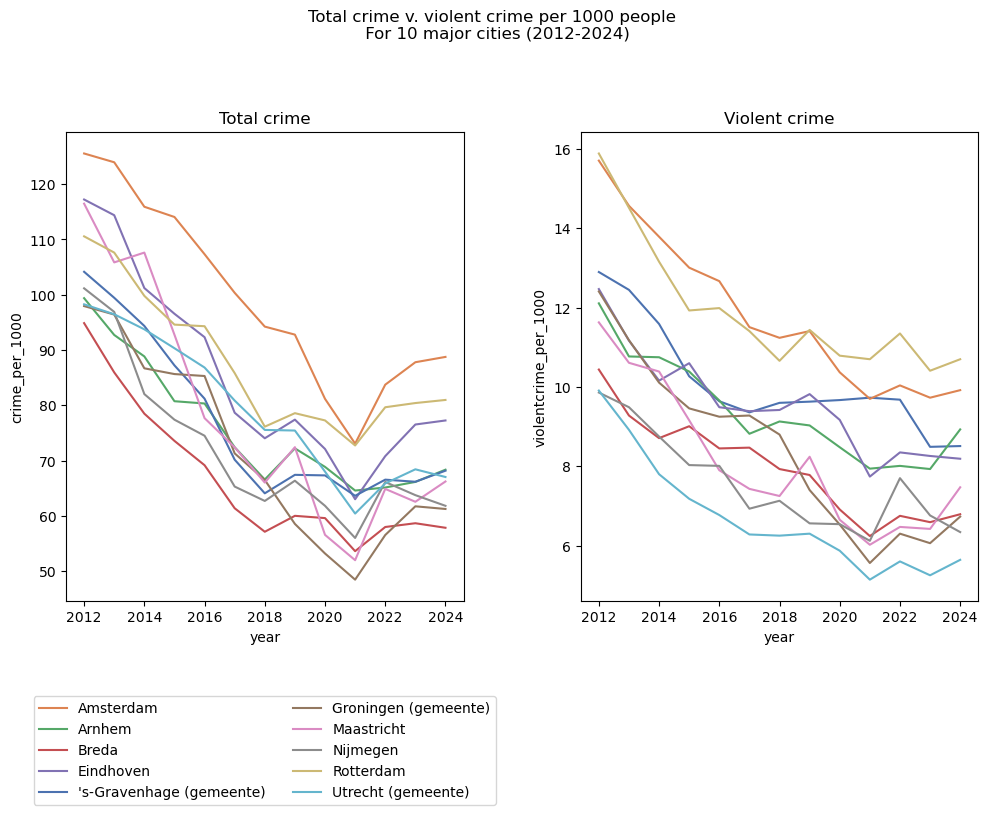

In [845]:
## Compare progression over time for total crime v. violent crime for 10 major cities
mjc_violent10 = cities_violent[cities_violent['region'].isin(top10_gemeenten['region'])][['region','year','violentcrime_per_1000']]

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True)

# Define a consistent color palette for regions
regions = sorted(pd.unique(top10_gemeenten['region']))
palette = sns.color_palette('deep', n_colors=len(regions))
region_to_color = dict(zip(regions, palette))

# Plot full timeline top 10 major cities for total crime
sns.lineplot(
    data=top10_gemeenten,
    x='year',
    y='crime_per_1000',
    hue='region',
    palette=region_to_color,
    ax=axs[0],
    legend=True
)

# Plot full timeline top 10 major cities for violent crime
mjc_violent10 = cities_violent[cities_violent['region'].isin(top10_gemeenten['region'])]

sns.lineplot(
    data=mjc_violent10,
    x='year',
    y='violentcrime_per_1000',
    hue='region',
    ax=axs[1],
    legend=False,
    palette=region_to_color
)

# Set titles
f.suptitle('Total crime v. violent crime per 1000 people \n For 10 major cities (2012-2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')

# Set legend location
axs[0].legend(
    bbox_to_anchor=(0.5, -0.2), 
    loc='upper center',          
    ncol=2,                      
    borderaxespad=0.1            
)

f.tight_layout()
## Export plot
plt.savefig("totalvviolent_line_majorcities.png", dpi=300, bbox_inches="tight")
plt.show()


## In 2024

While looking at how past trends arrived at the present is useful, what most people care about is: which cities are the most dangerous now? Instead of looking at a selection of 10 major cities that had the highest average total crime rates over time, we'll now look at which cities had the highest total and violent crime rates in just 2024. 

The bar charts below show both the top 10 cities in terms of total crime and in terms of violent crime rate in 2024.

For the top cities for 2024 total crime rate, we see many of the same cities we saw when looking at the top cities in terms of long term average total crime rate. Amsterdam once again tops the list for total crime rate, followed by Rotterdam and Eindhoven. Other cities that were not in our examination of long term trends also appear as top cities for total crime in 2024, such as Heerlen, Schiedam, Arnhem and Roermond.

Many of the same cities are also present in the top 10 ranking for violent crime rate in 2024, although in a very different order. While Heerlen comes in 5th place for their total crime rate in 2024, it takes 1st place for its violent crime rate together with Rotterdam. And while Amsterdam took 1st place for total crime, it comes in 2nd place for violent crime in 2024 together with Cranendonck.

One interesteing pattern is that a number of cities in Limburg show up in the ranking for total and violent crime for 2024, including some lesser known municipalities like Heerlen and Cranendonck. However, this tracks with the pattern we saw in the regional trends for total crime, where Limburg as a region took 3rd place.

### Summary table: all major cities

In [846]:
## Subset for 2024 total in major cities
mjcities_total_2024 = mjcities_total[mjcities_total['year'] == 2024]

## Subset for 2024 violent crime in major cities
mjcities_violent_2024 = cities_violent[(cities_violent['region'].isin(major_cities)) & (cities_violent['year'] == 2024)]

mjcities_summary_2024 = pd.merge(mjcities_total_2024.drop(columns='crime_type'), mjcities_violent_2024.drop(columns='crime_type'), on=['region','year'], how='inner', suffixes=['_total','_violent'])
mjcities_summary_2024 = (
    mjcities_summary_2024
    .drop(columns=['index'])        
    .sort_values(by='violentcrime_per_1000', ascending=False)
)
mjcities_summary_2024

,region,year,crime_count,population,crime_per_1000,violent_crime_count,violentcrime_per_1000
12,Rotterdam,2024,54503,672960,80.99,7206,10.70
0,Amsterdam,2024,82955,934526,88.77,9262,9.92
1,Arnhem,2024,11581,169364,68.38,1513,8.93
5,'s-Gravenhage (gemeente),2024,38802,568945,68.20,4850,8.51
3,Eindhoven,2024,19246,249035,77.28,2039,8.19
10,Maastricht,2024,8318,125563,66.25,935,7.47
9,Leeuwarden,2024,7065,129973,54.36,889,6.84
2,Breda,2024,10927,188779,57.88,1284,6.79
13,Tilburg,2024,12701,230357,55.14,1559,6.77
8,'s-Hertogenbosch,2024,8954,161530,55.43,1087,6.75


### Top 10 cities

In [847]:
## Subset top 10 cities for total crime
top10_2024 = cities_df[cities_df['year']==2024].sort_values(by=['crime_per_1000'], ascending=False).head(10)
top10_2024 = top10_2024[['year','region','crime_per_1000']].reset_index(drop=True)
## Subset top 10 cities for violent crime
violent10_2024 = (
    cities_violent[cities_violent['year'] == 2024][['region','violentcrime_per_1000']]
    .sort_values(by='violentcrime_per_1000', ascending=False)
    .head(10)
)

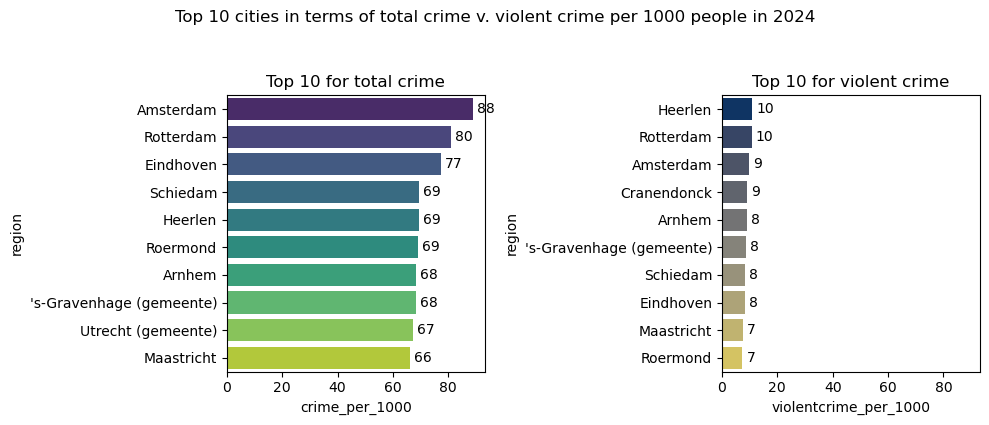

In [848]:
## Compare bar charts of top 10 cities in 2024 for total crime vs. violent crime

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True)

## Plot bar chart of top 10 cities in terms of total crime 2024
sns.barplot(data=top10_2024,
            x='crime_per_1000',
            y='region',
            hue='region', palette='viridis',
                ax=axs[0],
                legend=False)
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%d', label_type='edge', padding=3)


sns.barplot(data=violent10_2024,
            x='violentcrime_per_1000',
            y='region',
            hue='region',
                ax=axs[1], legend=False,
           palette='cividis')
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%d', label_type='edge', padding=3)

# Set titles
f.suptitle('Top 10 cities in terms of total crime v. violent crime per 1000 people in 2024', y=1.05)
axs[0].set_title('Top 10 for total crime')
axs[1].set_title('Top 10 for violent crime')


f.tight_layout()
## Export figure
plt.savefig("totalvviolent_bar_cities.png", dpi=300, bbox_inches="tight")
plt.show()


### Largest percent increases

Instead of looking at the cities with the highest total crime rates, we can also look at municipalities with the largest percentage changes in total crime rates.

The table below shows the 10 municipalities with the largest percentage increase in total crime between 2019-2024, compared to the percentage change in total crime rate nationally. The national total crime rate has decreased by 3.34% from 2019 to 2024.

<b><i>In contrast, the 10 municipalities that have experienced the largest percent increases in total crime rates have seen from a 20 to a 50% increase from 2019 to 2024.</b></i> Many of these municipalities will not be familiar to the average reader, as they tend to be much smaller than the larger and more well-known cities previously examined. 

But clearly, despite the national decreasing trend in crime, certain areas of the country are experiencing a much heavier burden of crime than they did pre-pandemic.

In [849]:
## Apply percent change function to national data
country_pctchange = (
    national_df[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)


## Apply percent_change function to calculate which cities have experienced the sharpest increase in total crime
total_pctchange = (
    cities_df[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
    .sort_values(by='pct_change_recent', ascending=False)
    .head(10)
)


## Concat both into new dataframe
compare_pctchange = pd.concat([country_pctchange, total_pctchange], axis=0).sort_values(by='pct_change_recent', ascending=False)
compare_pctchange.rename(columns={'pct_change_full':'% change total crime 2012-2024', 'pct_change_recent':'% change total crime 2019-2024'}, inplace=True)
compare_pctchange


C:\Users\chels\AppData\Local\Temp\ipykernel_31060\1605858132.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)
C:\Users\chels\AppData\Local\Temp\ipykernel_31060\1605858132.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)


,region,% change total crime 2012-2024,% change total crime 2019-2024
240,Veere,-16.71,50.12
104,Heemstede,-19.79,30.33
28,Bergen (L.),-8.29,29.80
129,Katwijk,-16.38,28.92
190,Reimerswaal,-21.81,27.46
37,Bloemendaal,-31.65,25.58
263,Wierden,-11.92,24.89
102,Hattem,-26.31,21.81
169,Oegstgeest,-16.11,20.58
110,Hellendoorn,-27.29,20.20


# 5) Do Randstad and Brabant cities differ in terms of crime rates?

### Over time

In [850]:
## Table of average crime per 1000 in each year per city grouping
bvr_groups = cities_df[(cities_df['region'].isin(brabant_cities))|(cities_df['region'].isin(randstad_cities))]

bvr_groups['city_group'] = np.where(
    bvr_groups['region'].isin(brabant_cities), 'Brabant',
    np.where(bvr_groups['region'].isin(randstad_cities), 'Randstad', None)
)

## Table of violent crime per 1000 in each year per city Brabant and Ranstad city
bvr_violent = cities_violent[((cities_violent['region'].isin(brabant_cities))|(cities_violent['region'].isin(randstad_cities)))]

bvr_violent['city_group'] = np.where(
    bvr_violent['region'].isin(brabant_cities), 'Brabant',
    np.where(bvr_violent['region'].isin(randstad_cities), 'Randstad', None)
)



C:\Users\chels\AppData\Local\Temp\ipykernel_31060\185368153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvr_groups['city_group'] = np.where(
C:\Users\chels\AppData\Local\Temp\ipykernel_31060\185368153.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvr_violent['city_group'] = np.where(


Text(0.5, 1.05, 'Total crimes per 1000 people for each major city in Randstad v. Brabant\n(2012-2024)')

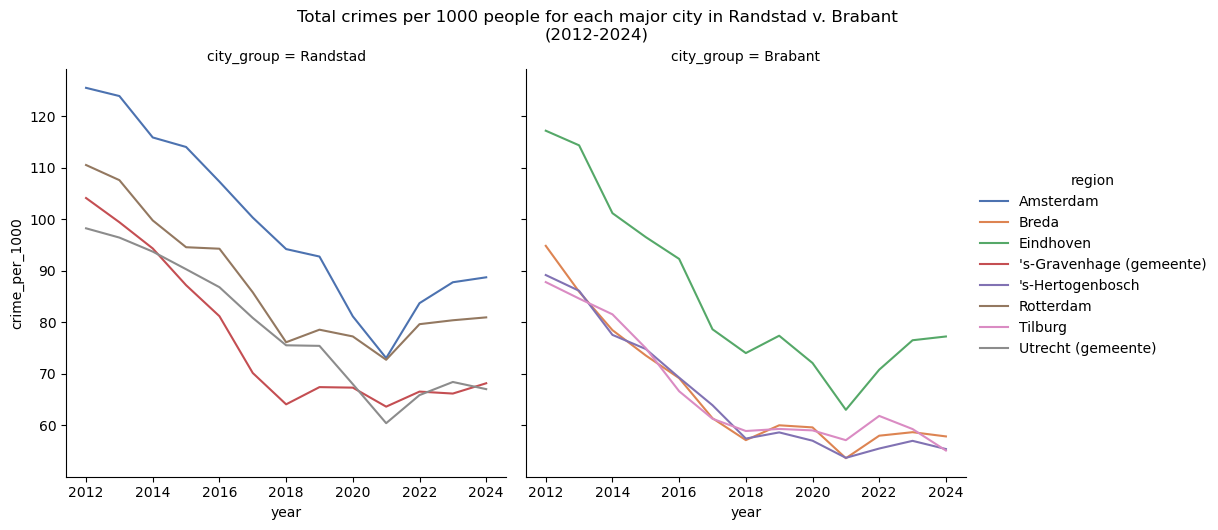

In [851]:
## Plotting trends in total crime among Randstad and Brabant cities
g = sns.relplot(data=bvr_groups, x="year", y="crime_per_1000", hue='region', col="city_group", kind='line', palette='deep')
g.set_axis_labels('year', 'crime_per_1000')
g.fig.suptitle(
    'Total crimes per 1000 people for each major city in Randstad v. Brabant\n(2012-2024)',
    y=1.05  
)

In [852]:
## Export figure
plt.savefig("totalcrime_line_randstadvbrabant.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.05, 'Violent crimes per 1000 people for each major city in Randstad v. Brabant\n(2012-2024)')

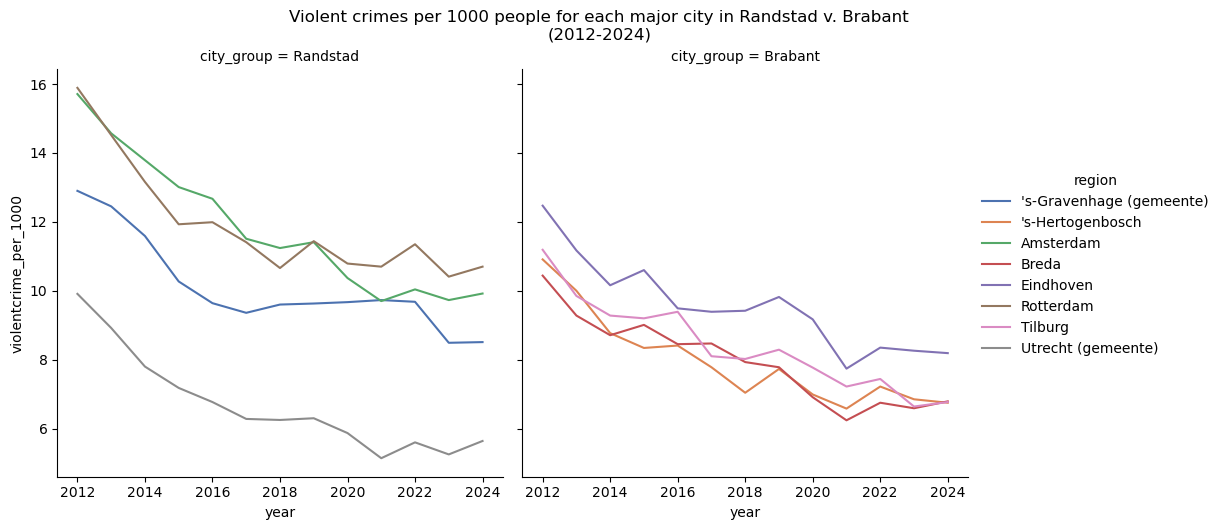

In [853]:
## Plotting trends in violent crime among Randstad and Brabant cities
g = sns.relplot(data=bvr_violent, x="year", y="violentcrime_per_1000", hue='region', col="city_group", kind='line',palette='deep')
g.set_axis_labels('year', 'violentcrime_per_1000')

g.fig.suptitle(
    'Violent crimes per 1000 people for each major city in Randstad v. Brabant\n(2012-2024)',
    y=1.05  
)

In [854]:
## Export figure
plt.savefig("violentcrime_line_randstadvbrabant.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [855]:
## Table of percent change in total crime for each Brabant and Randstad city, from 2012-2024 and from 2019-2024

bvr_pctchange = (
    bvr_groups[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)

bvr_pctchange.rename(columns={'pct_change_full':'% change total crime 2012-2024', 'pct_change_recent':'% change total crime 2019-2024'}, inplace=True)
bvr_pctchange.sort_values(by='% change total crime 2019-2024',ascending=False)

C:\Users\chels\AppData\Local\Temp\ipykernel_31060\2908588649.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)


,region,% change total crime 2012-2024,% change total crime 2019-2024
5,Rotterdam,-26.75,3.04
0,'s-Gravenhage (gemeente),-34.52,1.11
4,Eindhoven,-34.08,-0.19
3,Breda,-39.00,-3.60
2,Amsterdam,-29.30,-4.34
1,'s-Hertogenbosch,-37.87,-5.51
6,Tilburg,-37.23,-7.06
7,Utrecht (gemeente),-31.77,-11.13


### In 2024

The summary table and plot below indicate strong differences between the major cities in the Randstad and Brabant when looking at both total crime rates and violent crime rates in 2024.

As a group, the Brabant cities have substantially lower crime rates in 2024 compared to the Randstad cities, particularly in terms of violent crime. 

<b><i>Eindhoven, Rotterdam, Den Haag and Utrecht stand out as points of interest.</b></i> 

Although, as a group, the Randstad cities outrank Brabant cities on both fronts, Eindhoven outpaces not only Tilburg, Breda and Den Bosch, but also Den Haag and Utrecht in terms of 2024 total crime per 1000 people. 

Meanwhile, both Rotterdam and  Den Haag's violent crime rate rankings outpace their total crime rate rankings among the cities. 

Finally, Utrecht has a much lower violent crime rate in 2024 than any city in either group, a substantial divergence from the pattern for other Randstad cities.

#### Summary table

In [856]:
## Subset for 2024 total crime in Randstad and Brabant
bvrgroups_2024 = bvr_groups[bvr_groups['year'] == 2024]

## Subset for 2024 violent crime in Randstad and Brabant
bvrviolent_2024 = bvr_violent[bvr_violent['year']==2024]

bvrsummary_2024 = pd.merge(bvrgroups_2024.drop(columns='crime_type'), bvrviolent_2024.drop(columns='crime_type'), on=['region','year','city_group'], how='inner', suffixes=['_total','_violent'])
bvrsummary_2024.sort_values(by='violentcrime_per_1000', ascending=False)

,index,region,year,crime_count,population,crime_per_1000,city_group,violent_crime_count,violentcrime_per_1000
5,2781,Rotterdam,2024,54503,672960,80.99,Randstad,7206,10.70
0,363,Amsterdam,2024,82955,934526,88.77,Randstad,9262,9.92
3,1312,'s-Gravenhage (gemeente),2024,38802,568945,68.20,Randstad,4850,8.51
2,1104,Eindhoven,2024,19246,249035,77.28,Brabant,2039,8.19
1,727,Breda,2024,10927,188779,57.88,Brabant,1284,6.79
6,3119,Tilburg,2024,12701,230357,55.14,Brabant,1559,6.77
4,1624,'s-Hertogenbosch,2024,8954,161530,55.43,Brabant,1087,6.75
7,3210,Utrecht (gemeente),2024,25265,376757,67.06,Randstad,2127,5.64


#### Plot

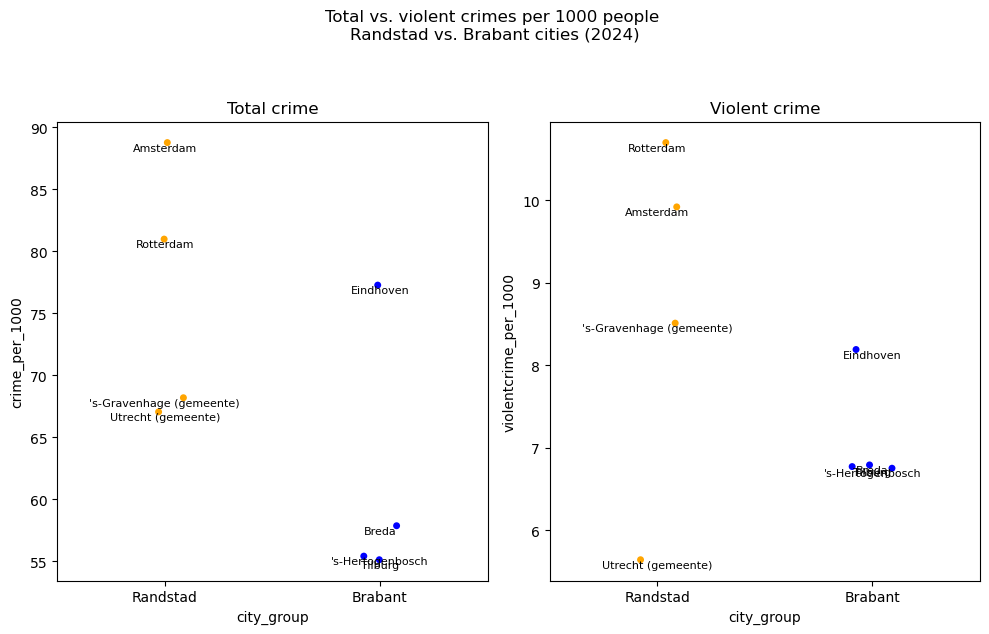

In [857]:
## Dual strip plot showing total crime vs. violent crime differences between major cities in Brabant v. Randstad

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True)


## Strip plot comparing total crime per city in each group for 2024
ax = sns.stripplot(data=bvrgroups_2024,
            x='city_group',
            y='crime_per_1000',
            hue='city_group',
                  jitter=True,
                  ax=axs[0],
                  legend=False,
                  palette=['orange','blue'])

## Strip plot comparing violent crime per city in each group for 2024
ax = sns.stripplot(data=bvrviolent_2024,
            x='city_group',
            y='violentcrime_per_1000',
            hue='city_group',
                  jitter=True,
                  ax=axs[1],
                  legend=False,
                  palette=['orange','blue'])

# Plot 2024 total crime levels for Randstad v. Brabant
for i, row in bvrgroups_2024.iterrows():
    axs[0].text(
        x=row['city_group'],  # x position (categorical, so use the category directly)
        y=row['crime_per_1000'],  # y position
        s=row['region'],  # Label from the 'time' column (replace with 'region' for your data)
        ha="center",
        va="top",
        fontsize=8)

## Plot 2024 violent crime levels for Randstad v. Brabant
for i, row in bvrviolent_2024.iterrows():
    axs[1].text(
        x=row['city_group'],  # x position (categorical, so use the category directly)
        y=row['violentcrime_per_1000'],  # y position
        s=row['region'],  # Label from the 'time' column (replace with 'region' for your data)
        ha="center",
        va="top",
        fontsize=8)


# Set titles
f.suptitle('Total vs. violent crimes per 1000 people \nRandstad vs. Brabant cities (2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')


f.tight_layout()
## Export figure
plt.savefig("totalvviolent_strip_randstadvbravant.png", dpi=300, bbox_inches="tight")
plt.show()

# (WORK IN PROGRESS) Correlations: Crime numbers v. population

In [858]:
## Check assumptions needed to calculate correlation

## Normality of features
# Shapiro-Wilk test on original data
stat, p = shapiro(gemeenten_totals['population'])
print(f"Shapiro-Wilk p-value for population: {p:.4f}")
stat, p = shapiro(gemeenten_totals['crime_per_1000'])
print(f"Shapiro-Wilk p-value for total crime per 1000: {p:.4f}")

probplot(gemeententotals_2024['population'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality - Population')
plt.show()

probplot(gemeententotals_2024['crime_per_1000'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality - Crime per 1000')
plt.show()

NameError: name 'gemeenten_totals' is not defined

In [ ]:
## Total crime vs. population (2024 levels)
gemeententotals_2024 = gemeenten_df[gemeenten_df['year'] == 2024]

# Check linearity and homoscedasticity
sns.scatterplot(data=gemeententotals_2024, x='population', y='crime_per_1000')
plt.title('Scatter Plot: Linearity and Homoscedasticity')
plt.show()

# Check for outliers
sns.boxplot(data=gemeententotals_2024[['population', 'crime_per_1000']])
plt.title('Boxplot: Outliers')
plt.show()

print('Population Outliers')
Q1 = gemeententotals_2024['population'].quantile(0.25)
Q3 = gemeententotals_2024['population'].quantile(0.75)
IQR = Q3 - Q1
outliers = gemeententotals_2024[(gemeententotals_2024['population'] < Q1 - 1.5 * IQR) | (gemeententotals_2024['population'] > Q3 + 1.5 * IQR)]
print(f"Number of population outliers: {outliers.shape[0]}")

print('Total crime per 1000 Outliers')
Q1 = gemeententotals_2024['crime_per_1000'].quantile(0.25)
Q3 = gemeententotals_2024['crime_per_1000'].quantile(0.75)
IQR = Q3 - Q1
outliers = gemeententotals_2024[(gemeententotals_2024['crime_per_1000'] < Q1 - 1.5 * IQR) | (gemeententotals_2024['crime_per_1000'] > Q3 + 1.5 * IQR)]
print(f"Number of total crime per 1000 outliers: {outliers.shape[0]}")


In [ ]:
# Standardize
scaler = StandardScaler()
gemeententotals_2024[['pop_scaled','crime1000_scaled']] = scaler.fit_transform(gemeententotals_2024[['population', 'crime_per_1000']])

# Plot
sns.regplot(
    data=gemeententotals_2024,
    x='pop_scaled',
    y='crime1000_scaled',
    line_kws={'color': 'red'}
)
plt.title('Standardized Data: Scatter Plot with Regression Line')
plt.show()

# Add correlation annotation
corr, p_val = spearmanr(gemeententotals_2024['population'], gemeententotals_2024['crime_per_1000'])
plt.text(0.05, 0.95, f"Spearman's r: {corr:.2f}", transform=plt.gca().transAxes, ha='left', va='top')


In [ ]:
## Violent crime vs. population (2024 levels); top 30 municipalities